# F4 Group - Data Science Project
This documentation regards the final project developed for the "Data Science" course (second module of the "Computational Management of Data" course, a.a. 2021/2022) within the Digital Humanities and Digital Knowledge Master's Degree at Alma Mater Studiorum - University of Bologna.

## The project
The goal of the project is to <b>develop a software</b> able to:
<ul>
<li><b>Process data</b> stored in <b>different formats</b> (such as CSV and JSON files)</li>
<li><b>Upload</b> the processed data in a <b>database</b> (relational or triplestore)</li>
<li><b>Query</b> the databases <b>simultaneously</b> using predefined operations</li>
</ul>

### The division of the workflow
The structure of the software can be seen in the following image:
# ![<Workflow structure>](imgs/workflow.png)
Initial creation of the class structure representing the data model in python was together as a group and later,the workflow was divided as follows:
<ul>
<li><b>Anita Liviabella</b> developed the RelationalDataProcessor and RelationalProcessor as well as the statistical analysis section</li>
<li><b>Giusy Grieco</b> developed the TriplestoreDataProcessor and TriplestoreProcessor as well as half of the queries of the TriplestoreQueryProcessor</li>
<li><b>Manu Srivastava</b> developed half of the queries of the TriplestoreQueryProcessor and the main part of the GenericQueryProcessor (main attributes and half of the methods)</li>
<li><b>Orsola Maria Borrini</b> developed all the queries of the RelationalQueryProcessor and half of the queries of the GenericQueryProcessor</li>
</ul>

## The software
The software was represented through a UML data model:
# ![<Software UML>](imgs/uml2.png)
As we can see, the expected results of the GenericQueryProcessor's queries are Python objects. The hierarchy of their classes and internal structures was also described through a UML data model:
# ![<Objects UML>](imgs/uml.png)
These Python classes have been implemented in the `dataModelClasses.py` file.

### Implementation of Python classes

The Python classes were defined in the `dataModelClasses.py` file. As it can be seen from the UML data model, all of the classes are dependant upon some other class <i>except for</i> the `IdentifiableEntity` class. For this reason, this was the first class to be implemented, while the order of the following implementations follows a "hierarchical" order: first, the four classes directly depending on the `IdentifiableEntity` class:
<ul>
<li>Organisation class</li>
<li>Venue class</li>
<li>Publication class</li>
<li>Person class</li>
</ul>

# ![<First layer objects UML>](imgs/UMLpy1.png)


In [123]:
class IdentifiableEntity(object):
    def __init__(self, ids):
        self.id = set()
        for item in ids:
            self.id.add(item)

    def getIds(self):
        return list(self.id)

class Person(IdentifiableEntity):
    def __init__(self, ids, givenName, familyName):
        self.givenName = givenName
        self.familyName = familyName
        super().__init__(ids)
    
    def getGivenName(self):
        return self.givenName
    
    def getFamilyName(self):
        return self.familyName

class Organisation(IdentifiableEntity):
    def __init__(self, ids, name):
        self.name = name
        super().__init__(ids)
    
    def getName(self):
        return self.name

class Venue(IdentifiableEntity):
    def __init__(self, ids, title, publisher):
        self.title = title
        self.publisher = publisher
        super().__init__(ids)
    
    def getTitle(self):
        return self.title
    
    def getPublisher(self):
        return self.publisher

class Publication(IdentifiableEntity):
    def __init__(self, ids, publicationYear, title, authors, publicationVenue, pcites):
        self.publicationYear = publicationYear
        self.title = title
        self.author = set()
        for aut in authors:
            self.author.add(aut)
        self.publicationVenue = publicationVenue
        self.cites = set()
        for cit in pcites:
            self.cites.add(cit)
        super().__init__(ids)
    
    def getPublicationYear(self):
        return self.publicationYear
    
    def getTitle(self):
        return self.title
    
    def getCitedPublications(self):
        return list(self.cites)
    
    def getPublicationVenue(self):
        return self.publicationVenue
    
    def getAuthors(self):
        return self.author

Then, the classes that depend on these classes just defined (specifically, they depend on the classes `Publication` and `Venue`)

<ul>
<li>Publication class -> from this class depend other three classes: JournalArticle, BookChapter and ProceedingsPaper</li>
<li>Venue class -> from this class depend other three classes: Journal, Book and Proceedings</li>
</ul>

# ![<Second layer objects UML>](imgs/UMLpy2.png)


In [124]:
class JournalArticle(Publication):
    def __init__(self, ids, publicationYear, title, authors, publicationVenue, pcites, issue, volume):
        self.issue = issue
        self.volume = volume
        super().__init__(ids, publicationYear, title, authors, publicationVenue, pcites)
    
    def getIssue(self):
        return self.issue
    
    def getVolume(self):
        return self.volume

class BookChapter(Publication):
    def __init__(self, ids, publicationYear, title, authors, publicationVenue, pcites, chapterNumber):
        self.chapterNumber = chapterNumber
        super().__init__(ids, publicationYear, title, authors, publicationVenue, pcites)
    
    def getChapterNumber(self):
        return self.chapterNumber

class ProceedingsPaper(Publication):
    pass

class Journal(Venue):
    pass

class Book(Venue):
    pass

class Proceedings(Venue):
    def __init__(self, ids, title, publisher, event):
        self.event = event
        super().__init__(ids, title, publisher)
    
    def getEvent(self):
        return self.event

Moreover, it is worth pointing out that we also defined in the same file `dataModelClasses.py` the `QueryProcessor` class, that will then need to be imported in the files `extraGraphClasses.py` and `extraRelationalClasses.py` in order to correctly define and implement the classes `RelationalQueryProcessor` and `TriplestoreQueryProcessor`.

In [125]:
# ===== QUERYPROCESSOR DEFINITION SUPERCLASS OF THE RELATIONALQUERYPROCESSOR AND THE TRIPLESTOREQUERYPROCESSOR
class QueryProcessor(object):
    def __init__(self):
        pass

The tests for this part of the software can be found in the folder `testFiles > TEST_dataModelClasses.py`, in the repository of the project.

## The Relational part
### RelationalDataProcessor and RelationalProcessor

The definition of these two classes can be found in the `extraRelationalClasses.py` file.

The development of this section of the software started from the definition of the `RelationalProcessor` class, which is the `RelationalDataProcessor`'s superclass, and therefore must be defined before the last one.

# ![Relational UML part 1>](imgs/UMLrel1.png)


In [126]:
from logging import raiseExceptions
from re import X
import sqlite3 as sql3
from unittest import result
from wsgiref.validate import IteratorWrapper
import pandas as pd
import json

class RelationalProcessor(object):
    def __init__(self): #constructor
        self.dbPath = "" #path of the database
    
    def getDbPath(self): 
        return self.dbPath #method that returns the path of the database.
    
    def setDbPath(self,path):
        if type(path)==str:
            self.dbPath = path   #set a new path for the database
            return True
        else:
            return False

I've defined the class within its constructur and methods: the variable `dbPath` contains the path of the database (a string), initially set as an empty string, that will be updated with the method `setDbPath` . The `getDbPath` returns the path of the database (returns a string), the `setDbPath` enables to set a new path for the database to handle (returns a boolean)
Then, I was able to define the `RelationalDataProcessor` subclass within its contructur and `super().__init__()` function, which returns a temporary object of the parent class. This allows us to call the methods from inside the parent class.

In [127]:
class RelationalDataProcessor(RelationalProcessor):
    def __init__(self):
        super().__init__() 

Then I've moved to the `uploadData` method which enables to upload the collection of data specified in the input file path (either in CSV or JSON) into the relational database.
First of all, the method take as parameters `self` and `filepath`, then I check if the input filepath it's not a string, in case it's a string I am able to proceed. 
Moving forward, I specified the format in which the data are stored, if it's a CSV file or a JSON file, in order to do this, I used the `endswith` method for checking whether the `filepah` string ends with `".csv"` or `".json"`. For an appropriate description of these file section, go to the Data Analysis section of this Notebook.

Then I proceed according to the file format which the sofware will receive as an input file.
Our purpuse in the `uploadData` is to build a relational database, which is based on the relational model of data, relation in this context is a synonym of "table", the idea is that a relational database uses tables with columns and rows, where each row is idenfified by a unique key (an identifier, even implicit). Each table, in principle, represnt a type of entity (e.g publication or venue), where rows idenfity instances of that type of entity (e.g the article  with DOI “10.1162/qss_a_00023” or the venue “Quantitative Science Studies”) and columns represents values that can be attributed to that instance. 
Moving to the process of building our relational database:

#### If the filepath is a CSV file:
First of all, in order to translate our UML Data Model into a relational database, we need to implement it as a series of tables related to each other. The professor's suggestion was to:

Create one table for each concrete class (the classes that do not have any subclass), those are:

From `Publication` superclass:
<ul>
<li>JournalArticle</li>
<li>BookChapter</li>
<li>ProceedingsPaper</li>
</ul>

From `Venue` superclass:
<ul>
<li>Journal</li>
<li>Book</li>
<li>Proceedings</li>
</ul>

I've used pandas library in order to implement tables as dataframes. For each of these tables/classes, I consider them having 1 column for each attribute and relation.
In our case we are talking about the classes: `JournalArticle, BookChapter,ProceedingsPaper, Journal, Book, Proceedings, Organisation, Person`

First I put the CSV file into the python enviroment thanks to the `read_csv` funcion provided by pandas, I specify as parameters the `filepath` and `na_filter=False`, the last parameter is able to convert all the NaN values to blank spaces. I store all inside the `df_publications` variable, which can be printed as a dataframe.
Then, I am building my empty dataframes, specifying all the columns and the appropriate dtype. 

For what concerns the `JournalArticle` dataframe, for example, I am specifying as columns all the attributes and relations from the subclass and also the others that it inherits from the superclass.
I am doing the same for all the other dataframes. 
Then I am going to fill all the columns with data that I am able to extract from the `df_publication` dataframe.
I decided not to use a for loop because I read that it might be computationally more expensive than other procedures, so I decided to fill each column in a different way.
For instance, let's see again the `journal_article_df`:
I'll take singularly each single column of my dataframe (`issue, volume, publication_year, title, publication_venue, id, pub_type`) in order to fill them with data:
I take from df_publications the columns `"type"` which have values equal to `"journal-article"`.
I specify the column that I am looking for according to that type of publication.
I am using the astype method, in order to cast a pandas object to a specified `dtype`, furthermore, the` astype()` function also provides the capability to convert any suitable existing column to categorical type.
I am also replacing with the replace method all the `NaN` values with empty strings.
I am doing this for all the other dataframes. 

After creating such dataframes (one for each table), we can then store them in the relational database, using the `pandas.DataFrame.to_sql` method.
The package that we should use is `sqlite3`, a classic Python package that allows you to get in contact with the database for running querying, creating tables, managing data etc...
The function `connect` allows us to connect with an existing database or to create a new one, it works specifying in input a path to a file existing in your file system, that file is where you will store the tables of your database and the data related.
Opening the connection with the database will automatically create one if it does not exist yet.

I am opening the connection to my relational database, using the funcion connect, if the file is not existing it will create the `db.file` for us.
In the end I am committing all the operations. 

The tables that I've obtained are named:
- JournalArticle
- BookChapter
- ProceedingsPaper
- JournalTable
- BookTable
- ProceedingsTable

#### If the filepath is a JSON file
I am using the function `open` and the method `load` in order to handle the json file. 
The `load` method is used to read JSON encoded data from a file and convert it into Python dictionary.

I obtained a dictionary stored inside the jsondata variable, through which I am going to build the dataframes. 
In summary, I am taking each single key of the dictionary, those are:
- authors
- venues_id
- references 
- publishers

Taking `authors_df` as an example, I am building the empty dataframe using each authors key as a column and specifying the corrisponding `dtype`.
Then I am creating empty lists for each authors key.
In the next step I am specifying the authors variable, in which I will store the values of the key "authors" from the `jsondata` dictionary.
Then I am using two for loops in order to append values to the empty lists that we've created:

The external for loop is ciclying all the author's keys, the most external keys are doi_authors, in which inside are present more keys, those are: `family`, `given` and `orcid`.
So, for each `doi_authors` and for each value of the `doi_authors` I am appending all the values in the appropriate column (family, given, orcid).

In the end I am taking the dataframe columns and store the elements of the lists inside them.

I am proceding in the same way following the different structure of each key of the `jsondata` dictionary.

In the end I am again opening the database connection, with the `sql3.connect` method and storing all the tables with the `to_sql` method and then committing all the transactions with the `commit` method. 

The names of the tables that I've obtained are:
- AuthorsTable
- VenuesIdTable
- ReferencesTable
- PublishersTable 

In [128]:
class RelationalDataProcessor(RelationalProcessor):
    def __init__(self):
        super().__init__()
    
    def uploadData(self,filepath):
        if type(filepath) != str:   # Is it a string?
            return False
        else:   # Check the file format
            # =============== CSV UPLOAD DATA ===============
            if filepath.endswith(".csv"):
                df_publications = pd.read_csv(filepath,na_filter=False)

                # =============== PUBLICATION DATAFRAMES ===============

                journal_article_df = pd.DataFrame({
                    "issue": pd.Series(dtype="str"),
                    "volume": pd.Series(dtype="str"),
                    "publication_year": pd.Series(dtype="int"),
                    "title": pd.Series(dtype="str"),
                    "publication_venue": pd.Series(dtype="str"),
                    "id": pd.Series(dtype="str"),
                    "pub_type": pd.Series(dtype="str")
                })

                book_chapter_df = pd.DataFrame({
                    "chapter_number": pd.Series(dtype="str"),
                    "publication_year": pd.Series(dtype="int"),
                    "title": pd.Series(dtype="str"),
                    "publication_venue": pd.Series(dtype="str"),
                    "id": pd.Series(dtype="str"),
                    "pub_type": pd.Series(dtype="str")
                })

                proceeding_paper_df = pd.DataFrame({
                    "publication_year": pd.Series(dtype="int"),
                    "title": pd.Series(dtype="str"),
                    "publication_venue": pd.Series(dtype="str"),
                    "id": pd.Series(dtype="str"),
                    "pub_type": pd.Series(dtype="str")
                })

                journal_article_df['issue'] = df_publications[df_publications['type']== "journal-article"]['issue'].astype('str')
                journal_article_df['volume'] = df_publications[df_publications['type']== "journal-article"]['volume'].astype('str')
                journal_article_df['publication_year'] = df_publications[df_publications['type']== "journal-article"]['publication_year'].astype('int')
                journal_article_df['title'] = df_publications[df_publications['type']== "journal-article"]['title'].astype('str')
                journal_article_df['publication_venue'] = df_publications[df_publications['type']== "journal-article"]['publication_venue'].astype('str')
                journal_article_df['id'] = df_publications[df_publications['type']== "journal-article"]['id'].astype('str')
                journal_article_df['pub_type'] = df_publications[df_publications['type']== "journal-article"]['type'].astype('str')
                journal_article_df.replace(to_replace="nan",value="")

                book_chapter_df['publication_year'] = df_publications[df_publications['type']== "book-chapter"]['publication_year'].astype('int')
                book_chapter_df['title'] = df_publications[df_publications['type']== "book-chapter"]['title'].astype('str')
                book_chapter_df['chapter_number'] = df_publications[df_publications['type']== "book-chapter"]['chapter'].astype('str')
                book_chapter_df['publication_venue'] = df_publications[df_publications['type']== "book-chapter"]['publication_venue'].astype('str')
                book_chapter_df['id'] = df_publications[df_publications['type']== "book-chapter"]['id'].astype('str')
                book_chapter_df['pub_type'] = df_publications[df_publications['type']== "book-chapter"]['type'].astype('str')
                book_chapter_df.replace(to_replace="nan",value="")
                

                proceeding_paper_df['publication_year'] = df_publications[df_publications['type']== "proceedings-paper"]['publication_year'].astype('int')
                proceeding_paper_df['title'] = df_publications[df_publications['type']== "proceedings-paper"]['title'].astype('str')
                proceeding_paper_df['publication_venue'] = df_publications[df_publications['type']== "proceedings-paper"]['publication_venue'].astype('str')
                proceeding_paper_df['id'] = df_publications[df_publications['type'] == "proceedings-paper"]['id'].astype('str')
                proceeding_paper_df['pub_type'] = df_publications[df_publications['type']== "proceedings-paper"]['type'].astype('str')
                proceeding_paper_df.replace(to_replace="nan",value="")

                # =============== VENUES DATAFRAMES ===============

                journal_df = pd.DataFrame({
                    "name_venue": pd.Series(dtype="str"),
                    "publisher": pd.Series(dtype="str"),
                    "id_venue": pd.Series(dtype="str"),
                    "venue_type": pd.Series(dtype="str")
                })

                book_df = pd.DataFrame({
                    "name_venue": pd.Series(dtype="str"),
                    "publisher": pd.Series(dtype="str"),
                    "id_venue": pd.Series(dtype="str"),
                    "venue_type": pd.Series(dtype="str")
                })

                proceedings_df = pd.DataFrame({"event": pd.Series(dtype="str"),
                                               "name_venue": pd.Series(dtype="str"),
                                               "publisher": pd.Series(dtype="str"),
                                               "id_venue": pd.Series(dtype="str"),
                                                "venue_type": pd.Series(dtype="str")

                })

                journal_df['name_venue'] = df_publications[df_publications['venue_type'] == "journal"]['publication_venue'].astype('str')
                journal_df['publisher'] = df_publications[df_publications['venue_type'] == "journal"]['publisher'].astype('str')
                journal_df['id_venue'] = df_publications[df_publications['venue_type'] == "journal"]['id'].astype('str')
                journal_df['venue_type'] = df_publications[df_publications['venue_type'] == "journal"]['venue_type'].astype('str')
                journal_df.replace(to_replace="nan",value="")

                book_df['name_venue'] = df_publications[df_publications['venue_type'] == "book"]['publication_venue'].astype('str')
                book_df['publisher'] = df_publications[df_publications['venue_type'] == "book"]['publisher'].astype('str')
                book_df['id_venue'] = df_publications[df_publications['venue_type'] == "book"]['id'].astype('str')
                book_df['venue_type'] = df_publications[df_publications['venue_type'] == "book"]['venue_type'].astype('str')
                book_df.replace(to_replace="nan",value="")

                proceedings_df['event'] = df_publications[df_publications['venue_type'] == "proceedings"]['event'].astype('str')
                proceedings_df['name_venue'] = df_publications[df_publications['venue_type'] == "proceedings"]['publication_venue'].astype('str')
                proceedings_df['publisher'] = df_publications[df_publications['venue_type'] == "proceedings"]['publisher'].astype('str')
                proceedings_df['id_venue'] = df_publications[df_publications['venue_type'] == "proceedings"]['id'].astype('str')
                proceedings_df['venue_type'] = df_publications[df_publications['venue_type'] == "proceedings"]['venue_type'].astype('str')
                proceedings_df.replace(to_replace="nan",value="")

                # =============== DATABASE CONNECTION ===============

                with sql3.connect(self.dbPath) as rdb:
                    journal_article_df.to_sql("JournalArticleTable", rdb, if_exists="append", index=False)
                    book_chapter_df.to_sql("BookChapterTable", rdb, if_exists="append", index=False)
                    proceeding_paper_df.to_sql("ProceedingsPaperTable", rdb, if_exists="append", index=False)
                    journal_df.to_sql("JournalTable", rdb, if_exists="append", index=False)
                    book_df.to_sql("BookTable", rdb, if_exists="append", index=False)
                    proceedings_df.to_sql("ProceedingsTable", rdb, if_exists="append", index=False)
                    rdb.commit()
            
            # =============== JSON UPLOAD DATA ===============

            elif filepath.endswith(".json"):
                with open(filepath, "r", encoding="utf-8") as file:
                    jsondata = json.load(file)
                    
                    # =============== AUTHORS DATAFRAME ===============
                    authors_df = pd.DataFrame({
                        "doi_authors": pd.Series(dtype="str"),
                        "family": pd.Series(dtype="str"),
                        "given": pd.Series(dtype="str"),
                        "orcid": pd.Series(dtype="str")
                    })

                    family = []
                    given = []
                    orcid = []
                    doi_authors = []

                    authors = jsondata['authors']
                    for key in authors:
                        for value in authors[key]:
                            doi_authors.append(key)
                            family.append(value['family'])
                            given.append(value['given'])
                            orcid.append(value['orcid'])

                    authors_df['doi_authors'] = doi_authors
                    authors_df['family'] = family
                    authors_df['given'] = given
                    authors_df['orcid'] = orcid

                    # =============== VENUES DATAFRAME ===============

                    venues_id_df = pd.DataFrame({
                        "doi_venues_id": pd.Series(dtype="str"),
                        "issn_isbn": pd.Series(dtype="str"),
                    })

                    doi_venues_id = []
                    issn_isbn = []

                    venues_id = jsondata["venues_id"]
                    for key in venues_id:
                        for value in venues_id[key]:
                            doi_venues_id.append(key)
                            issn_isbn.append(value)

                    venues_id_df["doi_venues_id"] = doi_venues_id
                    venues_id_df["issn_isbn"] = pd.Series(issn_isbn)

                    # =============== REFERENCES DATAFRAME ===============

                    references_df = pd.DataFrame({
                        "og_doi": pd.Series(dtype="str"),
                        "ref_doi": pd.Series(dtype="str"),
                    })

                    og_doi = []
                    ref_doi = []

                    references = jsondata["references"]
                    for key in references:
                        for value in references[key]:
                            og_doi.append(key)
                            ref_doi.append(value)

                    references_df["og_doi"] = pd.Series(og_doi)
                    references_df["ref_doi"] = pd.Series(ref_doi)

                    # =============== PUBLISHER DATAFRAME ===============

                    publishers_df = pd.DataFrame({
                        "crossref": pd.Series(dtype="str"),
                        "id_crossref": pd.Series(dtype="str"),
                        "name_pub": pd.Series(dtype="str")
                    })

                    crossref = []
                    id_crossref = []
                    name_pub = []

                    publishers = jsondata["publishers"]
                    for key in publishers:
                        crossref.append(key)
                        id_crossref.append(publishers[key]["id"])
                        name_pub.append(publishers[key]["name"])

                    publishers_df["crossref"] = pd.Series(crossref)
                    publishers_df["id_crossref"] = pd.Series(id_crossref)
                    publishers_df["name_pub"] = pd.Series(name_pub)
                
                # =============== DATABASE CONNECTION ===============

                with sql3.connect(self.dbPath) as rdb:
                    authors_df.to_sql("AuthorsTable", rdb, if_exists="append", index=False)
                    venues_id_df.to_sql("VenuesIdTable", rdb, if_exists="append", index=False)
                    references_df.to_sql("ReferencesTable", rdb, if_exists="append", index=False)
                    publishers_df.to_sql("PublishersTable", rdb, if_exists="append", index=False)
                    rdb.commit()
            return True

### RelationalQueryProcessor

The structure of the `RelationalQueryProcessor` is described in the UML data model in the following way:
# ![Relational UML part 2>](imgs/UMLrel2.png)

As it can be seen, it doesn't have its own attributes or relations, but inherits everything from the two super-classes (basically only `RelationalProcessor`). 

In [129]:
class RelationalQueryProcessor(QueryProcessor,RelationalProcessor):
    def __init__(self):
        super().__init__()

#### The SQL queries

For what concerns the queries, we have decided to implement them in such a way that the resulting pandas dataframes would contain <b>all the information necessary for creating the corresponding object</b> in the next step (the `GenericQueryProcessor`).
We will analyse this logic for the first query, `getPublicationsPublishedInYear`.

##### The `getPublicationsPublishedInYear` Query

This query takes in input an integer (representing a certain year), and returns a DataFrame.
As in the `GenericQueryProcessor` this same query requires, as output, a list of `Publication` objects, we need to gather all the information needed to build such objects here.
This was done by referring to the `dataModelClasses.py` file, where the Python classes are defined: 

In [130]:
class Publication(IdentifiableEntity):
    def __init__(self, ids, publicationYear, title, authors, publicationVenue, pcites):
        self.publicationYear = publicationYear
        self.title = title
        self.author = set()
        for aut in authors:
            self.author.add(aut)
        self.publicationVenue = publicationVenue
        self.cites = set()
        for cit in pcites:
            self.cites.add(cit)
        super().__init__(ids)

We can see that a `Publication` object requires:
<ul>
<li>A list of ids (strings, they will be dois)</li>
<li>A publication year (integer)</li>
<li>A title (string)</li>
<li>A list of authors (Person objects, at least one)</li>
- As the authors are objects of class Person, we need to create such objects and therefore need the necessary information: a list of ids (strings, they will be orcids), a familyName (string) and a givenName (string)
<li>A publication venue (a Venue object, at most one)</li>
    - As the publication venue is an object of class Venue, we need to create such object and therefore need the necessary information: a list of ids (strings, they will be issn and/or isbn), a title (string), and a publisher (as the publisher is an Organisation object, we need its information: a ist of ids (strings) and a name (string))
<li>A list of cited publications (a list of Publication objects)</li>
    - For what concerns the cited publications, in the RelationalQueryProcessor we will select them only by their id (doi)
</ul>

To actually implement the query we then need to:
1. Open a connection to the database
2. Select, from the dataframes contained in the database, all the columns that contain the aforementioned informations
    - For what concerns "generic" queries such as those involving a Publication or a Venue we will need to make a UNION of queries, each involving one specific Publication or Venue table
        - In our case, we need to make a UNION between the same query applied on JournalArticleTable, BookChapterTable and ProceedingsPaperTable
        - In the case of a Venue, we need to make a UNION between the same query applied on JournalTable, BookTable and ProceedingsTable
3. When we have an input parameter that is being decided by the user, we need to consider it as a variable: inside the query we will use a placeholder whose value will then be substituted by whatever input parameter is passed (of course, even before the opening of the connection to the database, a check on the type of the input parameter is done)
4. We then execute the query, fetch all rows and transform the list of tuples (that is the result of a SQL query) in a pandas DataFrame

In [131]:
class RelationalQueryProcessor(QueryProcessor,RelationalProcessor):
    def getPublicationsPublishedInYear(self,year):
        if type(year) == int:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalTable.id_venue==VenuesIdTable.doi_venues_id WHERE publication_year='{pub_year}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM BookChapterTable LEFT JOIN AuthorsTable ON BookChapterTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN BookTable ON ReferencesTable.og_doi==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON BookTable.id_venue==VenuesIdTable.doi_venues_id WHERE publication_year='{pub_year}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM ProceedingsPaperTable LEFT JOIN AuthorsTable ON ProceedingsPaperTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN ProceedingsTable ON ReferencesTable.og_doi==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON ProceedingsTable.id_venue==VenuesIdTable.doi_venues_id WHERE publication_year='{pub_year}'".format(pub_year=year)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "chapter_number", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"])
        else:
            raiseExceptions("The input parameter is not an integer!")

##### The other queries
The same is done for the other queries:

In [132]:
class RelationalQueryProcessor(QueryProcessor,RelationalProcessor):
    def getPublicationsByAuthorId(self,id):
        if type(id) == str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id WHERE orcid='{orcid}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM BookChapterTable LEFT JOIN AuthorsTable ON BookChapterTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN BookTable ON ReferencesTable.og_doi==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON BookChapterTable.id==VenuesIdTable.doi_venues_id WHERE orcid='{orcid}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM ProceedingsPaperTable LEFT JOIN AuthorsTable ON ProceedingsPaperTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN ProceedingsTable ON ReferencesTable.og_doi==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON ProceedingsPaperTable.id==VenuesIdTable.doi_venues_id WHERE orcid='{orcid}'".format(orcid=id)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "chapter_number", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"])
        else:
            raiseExceptions("The input parameter is not a string!")
    
    def getVenuesByPublisherId(self,id):
        if type(id) == str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT issn_isbn, NULL AS event, name_venue, publisher, name_pub, venue_type FROM VenuesIdTable LEFT JOIN JournalTable ON VenuesIdTable.doi_venues_id==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref WHERE publisher='{pub_id}' UNION SELECT issn_isbn, NULL AS event, name_venue, publisher, name_pub, venue_type FROM VenuesIdTable LEFT JOIN BookTable ON VenuesIdTable.doi_venues_id==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref WHERE publisher='{pub_id}' UNION SELECT issn_isbn, event, name_venue, publisher, name_pub, venue_type FROM VenuesIdTable LEFT JOIN ProceedingsTable ON VenuesIdTable.doi_venues_id==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref WHERE publisher='{pub_id}'".format(pub_id=id)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result, columns=["issn_isbn", "event", "name_venue", "publisher", "name_pub", "venue_type"])
        else:
            raiseExceptions("The input parameter is not string!")

    def getPublicationInVenue(self,venueId):
        if type(venueId)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id WHERE issn_isbn='{venue_id}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM BookChapterTable LEFT JOIN AuthorsTable ON BookChapterTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN BookTable ON ReferencesTable.og_doi==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON BookChapterTable.id==VenuesIdTable.doi_venues_id WHERE issn_isbn='{venue_id}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM ProceedingsPaperTable LEFT JOIN AuthorsTable ON ProceedingsPaperTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN ProceedingsTable ON ReferencesTable.og_doi==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON ProceedingsPaperTable.id==VenuesIdTable.doi_venues_id WHERE issn_isbn='{venue_id}'".format(venue_id=venueId)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "chapter_number", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"])        
        else:
            raiseExceptions("The input parameter is not a string!")

    def getJournalArticlesInIssue(self,issue,volume,journalId):
        if type(issue)==str and type(volume)==str and type(journalId)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id WHERE issue='{issue}' AND volume='{volume}' AND issn_isbn='{journal_id}'".format(issue=issue, volume=volume, journal_id=journalId)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"]) 
        else:
            raiseExceptions("One or all the input parameter are not strings!")

    def getJournalArticlesInVolume(self,volume,journalId):
        if type(volume)==str and type(journalId)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id WHERE volume='{volume}' AND issn_isbn='{journal_id}'".format(volume=volume, journal_id=journalId)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"]) 
        else:
            raiseExceptions("One or all the input parameter are not strings!")

    def getJournalArticlesInJournal(self,journalId):
        if type(journalId)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id WHERE issn_isbn='{journal_id}'".format(journal_id=journalId)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"]) 
        else:
            raiseExceptions("One or all the input parameter are not strings!")

    def getProceedingsByEvent(self,eventPartialName):
        if type(eventPartialName)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT event, name_venue, publisher, issn_isbn, name_pub, venue_type FROM ProceedingsTable LEFT JOIN VenuesIdTable ON ProceedingsTable.id_venue==VenuesIdTable.doi_venues_id LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref WHERE event LIKE '%{event}%'".format(event=eventPartialName)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["event","name_venue","publisher","issn_isbn", "name_pub", "venue_type"])
        else:
            raiseExceptions("The input parameter is not string!")

    def getPublicationAuthors(self,publicationId):
        if type(publicationId)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT doi_authors, family, given, orcid FROM AuthorsTable WHERE doi_authors='{pub_doi}'".format(pub_doi=publicationId)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["doi_authors", "family", "given", "orcid"])
        else:
            raiseExceptions("The input parameter is not string!")

    def getPublicationsByAuthorName(self,authorPartialName):
        if type(authorPartialName)==str:
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                query = "SELECT publication_year, title, publication_venue, id, issue, volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id WHERE family LIKE '%{family}%' OR given LIKE '%{given}%' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM BookChapterTable LEFT JOIN AuthorsTable ON BookChapterTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN BookTable ON ReferencesTable.og_doi==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON BookChapterTable.id==VenuesIdTable.doi_venues_id WHERE family LIKE '%{family}%' OR given LIKE '%{given}%' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM ProceedingsPaperTable LEFT JOIN AuthorsTable ON ProceedingsPaperTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN ProceedingsTable ON ReferencesTable.og_doi==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON ProceedingsPaperTable.id==VenuesIdTable.doi_venues_id WHERE family LIKE '%{family}%' OR given LIKE '%{given}%'".format(family=authorPartialName,given=authorPartialName)
                cur.execute(query)
                result = cur.fetchall()
                qrdb.commit()
            return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "chapter_number", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"]) 
        else:
            raiseExceptions("One or all the input parameter are not strings!")
            
    def getDistinctPublishersOfPublications(self,pubIdList):
        if type(pubIdList) == list and all(isinstance(n, str) for n in pubIdList):
            with sql3.connect(self.getDbPath()) as qrdb:
                cur = qrdb.cursor()
                result = list()
                for item in pubIdList:
                    query = "SELECT name_venue, id_venue, crossref, name_pub, venue_type FROM JournalTable LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref WHERE id_venue='{doi}' UNION SELECT name_venue, id_venue, crossref, name_pub, venue_type FROM BookTable LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref WHERE id_venue='{doi}' UNION SELECT name_venue, id_venue, crossref, name_pub, venue_type FROM ProceedingsTable LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref WHERE id_venue='{doi}'".format(doi = item)
                    cur.execute(query)
                    result_q = cur.fetchall()
                    result.extend(result_q)
                qrdb.commit()
            return pd.DataFrame(data=result, columns=["name_venue", "id_venue", "crossref", "name_pub", "venue_type"])
        else:
            raiseExceptions("The input parameter is not a list or it is not a list of strings!")

There is a couple of "particular" queries: the `getMostCitedPublication()`, the `getMostCitedVenue()` and the additional query `getPublicationsFromDOI(pubIdList)` (which is needed in the `GenericQueryProcessor`).

##### The `getMostCitedPublication` and the `getMostCitedVenue` Query
For the development of these two queries, given our starting requirement for each query (getting, as a result, a dataframe containing all the necessary information for building the expected Python objects in the `GenericQueryProcessor`), two different SQL queries were written and their results then merged.

1. In the first query we select select all the cited Publication dois and the number of citations involving them (ordering them in descending order)
2. We cannot be sure that the most cited Publication is the first row of the resulting dataframe, as there could be many Publications that deserve the top-place (being cited the same number of times)
3. We then save these top-cited Publications in a list and transform it into a dataframe
4. In the second query we retrieve all the information needed to create these Publication objects
5. At the end we merge the two dataframes

In [133]:
class RelationalQueryProcessor(QueryProcessor,RelationalProcessor):
    def getMostCitedPublication(self):
        with sql3.connect(self.getDbPath()) as qrdb:
            cur = qrdb.cursor()
            query1 = "SELECT ref_doi, COUNT(ref_doi) AS num_citations FROM ReferencesTable GROUP BY ref_doi ORDER BY num_citations DESC"
            cur.execute(query1)
            result_q1 = cur.fetchall()
            max = result_q1[0][1]
            result1 = list()
            for item in result_q1:
                index = result_q1.index(item)
                if result_q1[index][1] == max:
                    tpl = tuple((result_q1[index][0],max))
                    result1.append(tpl)
            df1 = pd.DataFrame(data=result1,columns=["ref_doi","num_citations"])
            query2 = "SELECT publication_year, title, publication_venue, id, issue, volume, NULL AS chapter_number, family, given, orcid, ref_doi, name_venue, issn_isbn, publisher, name_pub FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalArticleTable.id==VenuesIdTable.doi_venues_id UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, chapter_number, family, given, orcid, ref_doi, name_venue, issn_isbn, publisher, name_pub FROM BookChapterTable LEFT JOIN AuthorsTable ON BookChapterTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN BookTable ON ReferencesTable.og_doi==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON BookChapterTable.id==VenuesIdTable.doi_venues_id UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, NULL AS chapter_number, family, given, orcid, ref_doi, name_venue, issn_isbn, publisher, name_pub FROM ProceedingsPaperTable LEFT JOIN AuthorsTable ON ProceedingsPaperTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN ProceedingsTable ON ReferencesTable.og_doi==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON ProceedingsPaperTable.id==VenuesIdTable.doi_venues_id"
            cur.execute(query2)
            result_q2 = cur.fetchall()
            df2 = pd.DataFrame(data=result_q2,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "chapter_number", "family", "given", "orcid", "ref_doi", "name_venue", "issn_isbn", "publisher", "name_pub"])
            final_result = pd.merge(left=df2, right=df1, left_on="id", right_on="ref_doi")
            qrdb.commit()
        return final_result
    
    def getMostCitedVenue(self):
        with sql3.connect(self.getDbPath()) as qrdb:
            cur = qrdb.cursor()
            query1 = "SELECT name_venue, COUNT(name_venue) as num_cit FROM JournalTable LEFT JOIN ReferencesTable ON JournalTable.id_venue==ReferencesTable.ref_doi WHERE ref_doi IS NOT NULL GROUP BY name_venue UNION SELECT name_venue, COUNT(name_venue) as num_cit FROM BookTable LEFT JOIN ReferencesTable ON BookTable.id_venue==ReferencesTable.ref_doi WHERE ref_doi IS NOT NULL GROUP BY name_venue UNION SELECT name_venue, COUNT(name_venue) as num_cit FROM ProceedingsTable LEFT JOIN ReferencesTable ON ProceedingsTable.id_venue==ReferencesTable.ref_doi WHERE ref_doi IS NOT NULL GROUP BY name_venue ORDER BY num_cit DESC"
            cur.execute(query1)
            result_q1 = cur.fetchall()
            max = result_q1[0][1]
            result1 = list()
            for item in result_q1:
                index = result_q1.index(item)
                if result_q1[index][1] == max:
                    result1.append(result_q1[index][0])
            df1 = pd.DataFrame(data=result1,columns=["name_venue"])
            query2 = "SELECT issn_isbn, NULL AS event, name_venue, publisher, name_pub, venue_type FROM VenuesIdTable LEFT JOIN JournalTable ON VenuesIdTable.doi_venues_id==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref UNION SELECT issn_isbn, NULL AS event, name_venue, publisher, name_pub, venue_type FROM VenuesIdTable LEFT JOIN BookTable ON VenuesIdTable.doi_venues_id==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref UNION SELECT issn_isbn, event, name_venue, publisher, name_pub, venue_type FROM VenuesIdTable LEFT JOIN ProceedingsTable ON VenuesIdTable.doi_venues_id==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref"
            cur.execute(query2)
            result_q2 = cur.fetchall()
            df2 = pd.DataFrame(data=result_q2, columns=["issn_isbn", "event", "name_venue", "publisher", "name_pub", "venue_type"])
            final_result = pd.merge(left=df2, right=df1, left_on="name_venue", right_on="name_venue")
            qrdb.commit()
        return final_result

##### The `getPublicationsFromDOI`
We have also implemented this additional query that will be needed in the `GenericQueryProcessor`: what it does is it retrieves all the Publications' information starting from a list of ids (doi strings).

In [134]:
class RelationalQueryProcessor(QueryProcessor,RelationalProcessor):
    def getPublicationsFromDOI(self,pubIdList):
            if type(pubIdList) == list and all(isinstance(n, str) for n in pubIdList):
                with sql3.connect(self.getDbPath()) as qrdb:
                    cur = qrdb.cursor()
                    result = list()
                    for item in pubIdList:
                        query = "SELECT publication_year, title, publication_venue, id, issue, volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM JournalArticleTable LEFT JOIN AuthorsTable ON JournalArticleTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN JournalTable ON ReferencesTable.og_doi==JournalTable.id_venue LEFT JOIN PublishersTable ON JournalTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON JournalTable.id_venue==VenuesIdTable.doi_venues_id WHERE id='{doi}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM BookChapterTable LEFT JOIN AuthorsTable ON BookChapterTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN BookTable ON ReferencesTable.og_doi==BookTable.id_venue LEFT JOIN PublishersTable ON BookTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON BookTable.id_venue==VenuesIdTable.doi_venues_id WHERE id='{doi}' UNION SELECT publication_year, title, publication_venue, id, NULL AS issue, NULL AS volume, NULL AS chapter_number, pub_type, family, given, orcid, ref_doi, issn_isbn, publisher, name_pub, venue_type FROM ProceedingsPaperTable LEFT JOIN AuthorsTable ON ProceedingsPaperTable.id==AuthorsTable.doi_authors LEFT JOIN ReferencesTable ON AuthorsTable.doi_authors==ReferencesTable.og_doi LEFT JOIN ProceedingsTable ON ReferencesTable.og_doi==ProceedingsTable.id_venue LEFT JOIN PublishersTable ON ProceedingsTable.publisher==PublishersTable.crossref LEFT JOIN VenuesIdTable ON ProceedingsTable.id_venue==VenuesIdTable.doi_venues_id WHERE id='{doi}'".format(doi=item)
                        cur.execute(query)
                        result_q = cur.fetchall()
                        result.extend(result_q)
                    qrdb.commit()
                return pd.DataFrame(data=result,columns=["publication_year", "title", "publication_venue", "id", "issue", "volume", "chapter_number", "pub_type", "family", "given", "orcid", "ref_doi", "issn_isbn", "publisher", "name_pub", "venue_type"])
            else:
                raiseExceptions("The input parameter is not a list or it is not a list of strings!") 

The tests for this part of the software can be found in the folder `testFiles > TEST_extraRelationalClasses.py`, in the repository of the project.

## The Triplestore part
### TriplestoreDataProcessor and TriplestoreProcessor

TRIPLESTORE PROCESSOR

My(Guisy) personal experience in this project taught me one thing above all: is not how much you know "how to code", but how you create and practice your logic. As the professor said at the very beginning of the course, I found myself practicing the hacking style (in the best sense of the term of course) at the highest level here.
Indeed, when I asked for an external help, I understood some things that to me were not so clear before, even if I moved well on Pandas dataframes, rdf lib syntax and csv and json structure in general. 

In particular, what I figured it out is that: 1) while using RDFLIb, you can effectively query the SPARQL Store, after opening and closing the connection to it: this allows you to navigate the graph literally. 2)At a certain point in my research I thought i needed some async functions importing the time library; one thing I understood is that, when there is the ingestion of some files uploaded by the user, you can think of the situation of the software as a blak-or-white-situation: before the user input, after the user input. This means that, instead of thinking of the upload in itself, I relied on two different situations: if the graph was already populated with some triples or not. And then I acted in consequence. 3)I acted in consequence with what I call in the comments "caches", i.e. initially empty dictionaries, and empty lists. These two were the most powerful instruments to deal with structured (.csv) and hierarchical (.json) data.

Expected result: use of multliple methods called by the main uploadData, to set the steps of the process (ingesting, cleaning, populating a graph, output). Avoiding Spaghetti Coding. Coding well all the time. A function beginning in an elegant way.

<b>Pain:</b> How to deal with different files, in different formats (basically two) coming in the same time from the user - How to store this in triple-based forms - How to query inside the graph while populating it.

<b>Gain:</b> the developing part relies on the main structure and methods offered by Pandas, rdflib and SPARQL query.

<b>Result:</b> spaghetti coding still there (if-else loop dominate the scenario). The software provides reliable outputs.

 # ![Triplestore UML part 1>](imgs/UMLgraph1.png)

For the interaction with the Blazegraph, these are the chosen URIRef and the base url:

JournalArticle = URIRef("https://schema.org/ScholarlyArticle")
BookChapter = URIRef("https://schema.org/Chapter")
Journal = URIRef("https://schema.org/Periodical")
Book = URIRef("https://schema.org/Book")
Proceedings = URIRef("https://schema.org/EventSeries")
ProceedingsPaper = URIRef("http://purl.org/spar/fabio/ProceedingsPaper")
doi = URIRef("https://schema.org/identifier") #valid also for issn/isbn
publicationYear = URIRef("https://dbpedia.org/ontology/year")
title = URIRef("https://schema.org/name")
issue = URIRef("https://schema.org/issueNumber")
volume = URIRef("https://schema.org/volumeNumber")
chapter_num = URIRef("https://schema.org/numberedPosition")
publisher = URIRef("https://schema.org/publisher")
publicationVenue = URIRef("https://schema.org/isPartOf")
author = URIRef("https://schema.org/author")
name = URIRef("https://schema.org/givenName")
surname = URIRef("https://schema.org/familyName")
citation = URIRef("https://schema.org/citation")
event = URIRef("https://schema.org/event")

base_url = "https://FF.github.io/res/"

The above assignement if URIs for our class objects is done in the ```extraGraphClasses.py``` file

### THE CODE
What to do before instantiating a TripleStore Processor: please remember to open the connection to the BlazegraphDB. For more, follow Silvio Peroni indications on this topic here: https://github.com/comp-data/2021-2022/blob/main/docs/handson/06/06-Interacting_with_databases_using_Pandas.ipynb

<b>How to read it:</b> you will find comments in the .py file.

To check the real structure of files for the ingesting of data, see: https://github.com/comp-data/2021-2022/tree/main/docs/project

We begin by instanciating the main classes: Triplestore Processor and Triplestore Data Processor.
As one can notice, the Triplestore processor, by default, doen not return anything, except for the method setEndopointUrl, that takes in input the user-provided data path.
On the other hand, the Triple Store Data Processor is described by a method, called uploadData, which takes in input the user provided data path and returns a boolean value, in accordance with the correct uploading of data, and collateral populating of the graph.
The function is mainly divided in two parts: one for the csv data upload and one for the json data upload. This is possible through a conditional loop.
In each part, we have two possible scenarios taken in consideration, stored in a variable "storedTriples"; basically through the method __len__ we are able to know if in the store there are some triples or not.

There are 4 previously instanciated variables, that are empty dicitonaries and a Literal, that work as basic cache/counter which help for the storing process of the venues and publications.

<b>CSV FILE UPLOAD: FIRST CASE SCENARIO</b>

Let's now take as reference the case of a .csv uploding with an empty SPARQL store. Here the machine will go iterating over the dataframe obtained through the compulsive action of the read_csv method.

For every publication, the machine will set a unique identifier for local purposes, associated to the base_url of the FF resource path on github.
The value obtained by the concatenation of these two strings will end up being the subject of our first triple, and so on with the other publications.
In particular, the triples built from the csv file are read here in a Publication and Venue centric point of view. 
That's because we want that data stored in the "publications" dataframe becoming information in the triples.
So, the doi column data will become the object of the triple, according to the UML model, and the same will be for the title column and the publicationYear, that in the dataframe has been set as an integer value.

Again, according to the data model, we instantiate a conditional loop to tell the machine to add other triples, related to the subclasses of publication (journal article, book chapter, proceedings paper), according to the type of subclass, that we can read from the publications dataframe in the column "type".
The same thing happens for the venue class, in the sense that, after checking in my global variable (cache) if other venues have been stored, putting the case in which there are no other venues, I'll  populate venues-related triples: the subject will be the string obtained by the base_url of Fantastic Four GitHub resource + the number of the index. The number of the index is here obtained checking for the lenght of the relative cache (everytime a venue will be read, it will be authomatically put in the cache). Since the subclasses of Venue class are venue type, journal, book and proceedings, the machine will create the venue-related triples with the values obtained by the .csv data in the column "venue_type", both in the form of Literals and the subclass.

The exactly same process of 
<ul>
1) checking the cache 
2) updating the cache 
3) creating the triple, has been set for the publisher value, i.e. for the name of the Organization.
</ul>

<b>CSV FILE UPLOAD: SECOND CASE SCENARIO</b>

The second scenario (if storedTriples > 0) works more in a dynamic way in accordance with the store, that has been instantiated at the beginning.
Through basic SPARQL query syntax, we're able to access the information already present in the store, and consequentially act, populating the database, ideally again.
In the first query we're asking the machine to search for publications in the SPARQL store (put in the variable store), and we're retrieving from the obtained dataframe (named publicationOutput) the "lenght" (i.e. the number of publications) of the store through the method shape(). Since the shape() method gives as output a tuple of two values, we select only the first element of it.

Next step is to compare what publication doi we have in the user input .csv and in the store. So we create another query, that works upon the sample technique, as documented in the rdflib SPARQL documentation the value is retrieved through the format() method.
If (conditional loop) there are no dois stored in the output dataframe from the previous query, we instantiate a new subject, whose identifier is anyway obtained by the sum of the lenght of my publication counter (variable instantiated at the very beginning as a sort of global variable, even if it is not properly a global variable) and the lenght of my last query output dataframe.

In the same conditional loop of no results between the comparison of query-output-dataframe and my counter of publications (if comparePublicationsOutput.empty), we instantiate another query, to check the venues situation.

We expect that usually there will be no venue value stored yet, unless it comes from another csv file uploading operation. Here we ask the machine to compare the publication venues already in the store (if any) and the publication venues in the input data. Here we check if in our cache there are already some of the venues we're retrieving, and in this case we instantiate it as the subject. Of course this is again a for each loop, meaning that the just described passage suits every single venue.
The other side of the conditional loop is that the venue value read is already stored in the graph. In this case, we're telling the machine to create triples related to the subclasses of that value: as before, we're talking about journal, book and proceedings. Since the class proceedings present one attribute, i.e. "event", the machine will also add a triple according this.

Coming out from the conditional loop of the venues, we are back on the conditional loop, the publication-related one, according to which there are already some dois in the graph registered in a subject node. Now the work of the machine will be instead focused on to check if the current doi is already linked to a venue object node: this is done as usual through a SPARQL query. The result from this query is the "comparePublicationsAndVenues" dataframe. A set of conditional loops is instanciated: if the aforementioned dataframe is empty, then if the value provided by the .csv data is not in our cache, the machine will add it.

Otherwise, we'll instanciate another query "compareVenues" to check if the venues are already or not in our store and in our cache.
A similar comparison is done also for publishers, always in a publication-centric point of view.

<b>JSON FILE UPLOAD: FIRST AND SECOND CASE SCENARIO.</b>

In the second case, that of .json files, we retrieve the four main json objects: "authors", "venues", "references" and "publishers". The choosen way to explore the objects here is by instantiating some dataframes from the uploaded data.
For the very first object, we create four empty lists, that will become the series of the authors_df: one for doi, one for the name, one for the surname and one for the related orcid. Furthermore, we create also other three empty lists, to keep the counting of the family, given and orcid. These latest lists will be appended to the main list (family, given, orcid).

For the venues object, we will do basically the same operation (list->Series->Dataframe), creating one list more to store in general the issn/isbn of the venue to keep track of them (as a cache) and one list more with the same purpose containing the related dois.
A similar process follows for publisher object and references object.
Finally, since the dois retrieved from the object authors could be related to some venues (remember that the main key of the object venue is, indeed, a doi) we decide to (out) merge the venuesids dataframe, together with the authors dataframe, in case they could be linked together in a triple. Taking the output dataframe, we want to merge it with with the references, to check whether the (venues) dois can be linked with that one of the references.
Next step is to instanciate four dictionaries, one for every object rendered in a dataframe.
As before we will have the two scenarios: storedTriples == 0 and storedTriples > 0. In both cases, we'll continue using a publication/venue-centred approach, in the sense that, also for the "additional information" coming from the json file, I'll first of all retrieve the relative doi/issn or isbn, check whether they are or not already in my cache, and act on consequence, maintaining the publication and the venue as subjects of the triples.

At the very end of the function, we're able to open again the connection to the Blazegraph.

### TriplestoreQueryProcessor

The triplestore query processor acts based on a series of methods to retrieve information, through a SPARQL+rdflib syntax. This class acts as an extension of the Triplestore processor throuoh which we can access the content of the triplestore databases. It has not attributes of its own but has access to the endpoint URI through its parent class.

 #### The SPARQL queries

The following queries can be executed from the triplestoreQueryProcessor — 

 # ![Triplestore UML part 1>](imgs/UMLgraph2.png)|
 
 The top seven queries were scripted, in accordance with the workload distribution, by Giusy and the bottom six were scripted by Manu. In its current state, the bottom six queries do not work because of the error in uploading the data and to avoid giving errors from the generic query processor, we simply use the `pass` command in the bottom six queries. 
 
  Once can see the code for the SPARQL queries in the `extraGraphClasses.py` file in the github repository. To see how to the queries are supposed to work and what arguments are accepted by them, head over to the <b>Classes RelationalQueryProcessor and TriplestoreQueryProcessor section</b> on this link - https://github.com/comp-data/2021-2022/tree/main/docs/project


The tests for this part of the software can be found in the folder `testFiles > TEST_extraGraphClasses.py`, in the repository of the project.

## GenericQueryProcessor

The `GenericQueryProcessor` is structured as follows:
 # ![Generic UML part 1>](imgs/UMLgen.png)

`queryProcessor`: the variable containing the list of QueryProcessor objects to involve when one of the get methods below is executed. In practice, every time a get method is executed, the method will call the related method on all the `QueryProcessor` objects included in the variable queryProcessor, before combining the results and returning the requested object.
The definition of these two classes can be found in the `GenericQueryProcessor.py` file.

This section of the software will need, to work, the importation of the classes defined in the `extraRelationalClasses.py`, `extraGraphClasses.py` and `dataModelClasses.py` files.

### cleanQueryProcessors
This function is used to clean the list of queryProcessor from all the QueryProcessor objects it includes. The Code can be seen below -
### addQueryProcessor 
This function is used to append the input `QueryProcessor object` to the list queryProcessor which is an attribute of the genericQueryProcessor class. The genericQP can work with two different types of query processors, namely `RelationaQueryProcessor` and `TriplestoreQueryProcessor` which have been defined previously in the `extraRelationalClasses.py` and `extraGraphClasses.py` file. 

It allows the possiblity to work with multiple query processor objects but needs atleast one to exectue the queries.

In [1]:
class GenericQueryProcessor(object):
    def __init__(self):
        self.queryProcessor = list()

    def cleanQueryProcessors(self):
        self.queryProcessor = []
        return True

    def addQueryProcessor(self,processor):
        pClass = type(processor)
        if issubclass (pClass,QueryProcessor):
            self.queryProcessor.append(processor)
            return True
        else:
            return False

 #### The Queries
The queries of the `GenericQueryProcessor` were developed by Manu Srivastava and Orsola Maria Borrini, the former dealing with:
<ul>
<li>getPublicationsPublishedInYear</li>
<li>getPublicationsByAuthorId</li>
<li>getMostCitedPublication</li>
<li>getPublicationInVenue</li>
<li>getJournalArticlesInIssue</li>
<li>getJournalArticlesInVolume</li>
<li>getJournalArticlesInJournal</li>
<li>getPublicationsByAuthorName</li>
</ul>

While the latter mainly focused on those queries which did not involve any object of class `Publication`:
<ul>
<li>getMostCitedVenue</li>
<li>getVenuesByPublisherId</li>
<li>getProceedingsByEvent</li>
<li>getPublicationAuthors</li>
<li>getDistinctPublishersOfPublication</li>
</ul>

Aside from some specificities (analysed in the following paragraphs), the queries were structured as follows:
<ol>
<li>An empty dataframe (final_DF) was created to contain the results of the queries from the various query processors passed as input of the GenericQueryProcessor object </li>
<li>Iterate over the list of query processors (self.queryProcessor)</li>
<li>For each of these query processors (that could be of class RelationalQueryProcessor or TriplestoreQueryProcessor), the query is called and its resulting Dataframe saved in a variable result_DF</li>
<li>Each of these results is then concatenated to the final_DF which, at the end of the iteration, will contain <i>all</i> the results of the queries in <i>all</i> the query processors contained in the list</li>
<li>As the queries require, as output, a list of Python objects, the result list is then created (of course, empty)</li>
</ol>
From this point onwards, the logic of the queries changes depending on the requested output object.

##### The `Publication` and `JournalArticle` Queries

The queries scripted by Manu under the GenericQueryProcessor(GQP) deal with the creation of `Publication` and `JournalArticle` objects out of the retured results from the different query processors provided as argument to the GQP using the `addQueryProcessor` class method.

According to the definition of the constructor of the `Publication` and `JournalArticle` in the `dataModelClasses.py` file, we see that they require the citations for class instance creation and this required us to script a function to create `Publication` and `JournalArticle` class objects which requires some level recursive logic.

The constructor function code can be found in the `pubMemory_full.py` file. 

The functions work as follows, the genericQueryProcessor queries like `getPublicationsPublisherInYear` or `getJournalArticlesinJournal` which need to return the <b>publication</b> object and <b>JournalArticle</b> objects will be calling the the `creatPubobj` function which takes in the argument <b>DOI</b> you can see the script of the function in the code block below -

In [ ]:
citlist = set()
def MANUalrecursion(doilist):
    
    for item in doilist:
        if item == None:
            Noauth = Person("NO-Orcid","NO-Givenname","No-Familyname")
            autlist = set()
            autlist.add(Noauth)
            NoVenue = Venue("NO-VenueId","NO-VenueTitle",Organisation("NO-OrganisationID","NO-OrganisationTitle"))
            ender = Publication("NO-PubID","NO-PubYear","NO-Title",autlist,NoVenue,set())
            citlist.add(ender)
            pass
        else:
            citlist.add(creatPubobj(item))
    return citlist

def creatPubobj(DOI):   #creates class objects 
    Final_obj = {}
    Final_obj.update(mem[DOI])
    #print(Final_obj)
    #now we use the Final_obj dict to create our class object
    #first we create dependency objects like person object, venue object, etc
    # 1 - author object by iterating over the dict in the Final_obj dict
    aut = []
    for item in Final_obj['authors']:
        person = Person(item['orcid'],item['given'],item['family'])
        aut.append(person)
    #print(Final_obj['venue']['id'])
    if Final_obj['venue']['id'] == None:
        pass
    else:
        orgdata = {}
        orgdata.update(Final_obj['venue']['publisher'])
        publisherobj = Organisation(orgdata['id'],orgdata['title'])
        venueobj = Venue(Final_obj['venue']['id'],Final_obj['venue']['title'],publisherobj)
    
    if Final_obj['cites'] == None:
        pub_obj = Publication(Final_obj['doi'],Final_obj['year'],Final_obj['title'],aut,venueobj,set())
    else:
        pub_obj = Publication(Final_obj['doi'],Final_obj['year'],Final_obj['title'],aut,venueobj,MANUalrecursion(Final_obj['cites']))
    
    return pub_obj     

In the above code, the `Final_obj` is used to store the data from the `mem` variable which is populated with all the publication data using the function named `createPubobjsdict` which taken in a <b>Dataframe</b> which hold all the data required to create a publication object. 

Similarly, we have another function called `creatJAobj` which uses similar logic to create `JournalArticle` objects instead of `Publication` object.

In [ ]:
def createPubobjsdict(df):     # This DF contains all our publication data for one all our databases.
    for idx, item in df.iterrows():
        if item['id'] in mem:  #checks if we have alreay dealt with the the DOI in the df argument
            pass
        else:
            obj = {
                    "doi": [item['id']],
                    "title": item['title'],
                    "year":item['publication_year'],
                    "issue":item['issue'],
                    "volume":item['volume']
            }
            # ADDING AUTH LIST CREATED IN THE AUTHORLIST FUNCTION
            if item['id'] in tutti_author:    #check key
                auth_list = tutti_author[item['id']]  # json might have incomplete data
                obj.update({"authors":auth_list}) #adding dict of authors for this obj
            else:
                auth_list = {
                            "family": "No Data available",
                            "given": "No Data available",
                            "orcid": "No Data available"}
                obj.update({"authors":auth_list}) #adding dict of authors for this obj

            # CREATING AND ADDING VENUE AND PUBLISHER OBJECT
            if item['publication_venue'] == NULL:   #check syntax
                empt_publisher = {"id":"none//data nt available","title":"none//data nt available"}
                empt_venue = {"id":"none/data nt available", "title":"none/data nt available","publisher":empt_publisher}
                obj.update({'venue': empt_venue })
            else:
                org_data = {"id":[item["publisher"]],"title":item["name_pub"]}
                ven_data = {"id":[item['issn_isbn']],"title": item['publication_venue'], "publisher": org_data}
                obj.update({"venue":ven_data})
            mem.update({item['id']:obj})   #here we add the incomple obj to the mem dict
            
            #creating cites list
            cites_list = []
            cites_list.append(item['ref_doi'])
            obj.update({'cites': cites_list })


This dataframe used by the above shown function is created by another function called `df_creator` which takes in input a `dataprocessor` (code shown below). This function is called during the addintion of the queryProcessor objects to the GQP. It iterrates over the dictionay `tutti_author` which populated during the upload of the data from .json file uploaded using the upload data method of either the `relationalDataProcessor` or the `triplestoreDataProcessor`.

In [ ]:
def df_creator(z):
    sumDF = pd.DataFrame()
    for key in tutti_author:
        singDF1 = z.getPublicationsFromDOI([key])
        #singDF2 = c.getPublicationsFromDOI([key])  #this function is written but the query takes too long and probably goes on infinitely
        
        #sumDF_temp = pd.concat([singDF1,singDF2])
        sumDF = pd.concat([singDF1,sumDF])
        #print("This query takes time, please wait with a hot cup of coffee")
    createPubobjsdict(sumDF)
    return 

##### The `Venue`, `Person`, `Organisation` Queries
What we mean here is those queries that request, as output, a list of objects of `Venue`, `Person`, `Organisation` class:
<ul>
<li>getMostCitedVenue -> a Venue object </li>
<li>getVenuesByPublisherId -> list of Venue objects </li>
<li>getProceedingsByEvent -> list of Proceedings objects (Venue)</li>
<li>getPublicationAuthors -> list of Person objects </li>
<li>getDistinctPublishersOfPublication -> list of Organisation objects</li>
</ul>

After calling the query in the list of query processors (`self.queryProcessor`), we create an empty list (the `result` list) which will contain the python objects.

We then start iterating over the `final_DF` dataframe, saving all the information needed for each object:
<ul>
<li>Venue objects need a list of ids (strings, they will be issn and/or isbn), a title (string), and a publisher</li>
    - As the publisher is an Organisation object, we need to create such object and therefore need the necessary information: a list of ids (strings, they will be crossref) and a name (string)
<li>Proceedings objects need all the information needed by a Venue object and some additional information too: the event (string) </li> 
<li>Person objects need a list of ids (strings, they will be orcids), a familyName (string) and a givenName (string)</li>
<li>Organisation objects, as we have already seen with Venues, need a list of ids (strings, they will be crossref) and a name (string) </li>
</ul>

To save this information we scroll through the rows of the `final_DF` and save the values we need (which will be saved under specific columns).
Some information is required to be in the form of a list (ids):
<ul>
<li>Create an empty list which will contain all the values needed for each specific object</li>
<li>Save the first value in a variable</li>
<li>Start another iteration on the same dataframe</li>
<li>By using meaningful information that remains static for each object (for example, the name of the Venue or the id of the Publication), we can compare it between the two different iterations: if this static meaningful information stays the same, it means we are still in the same occurrence of object (and we add the needed information to the empty list), otherwise we are dealing with another occurrence (and don't add anything to the list)</li>
</ul>

Before moving on with another "main" iteration over the `final_DF`, we create the Python object and append it to the `result` list.

In [136]:
class GenericQueryProcessor(object):
    def getVenuesByPublisherId(self,id):
        # The id is going to be a crossref
        final_DF = pd.DataFrame()
        
        for item in self.queryProcessor:
            result_DF = item.getVenuesByPublisherId(id)
            final_DF = pd.concat([final_DF,result_DF])

        result = list()
        for idx,row in final_DF.iterrows():
            title = row["name_venue"] # -> "title"(of the Venue)
            ids_list = list() # -> ["ids"](=issn_isbn)
            for idx2,row2 in final_DF.iterrows():
                title2 = row2["name_venue"]
                if title2 == title:
                    # We are in the same Venue!
                    issn_isbn = row2["issn_isbn"]
                    ids_list.append(issn_isbn)
            crossref_list = list() # -> ["ids"](=crossref)
            for idx3,row3 in final_DF.iterrows():
                title3 = row3["name_venue"]
                if title3 == title:
                    crossref = row3["publisher"]
                    crossref_list.append(crossref)
            name_org = row["name_pub"]
            publ_obj = Organisation(crossref_list,name_org)
            venue_obj = Venue(ids_list,title,publ_obj)
            result.append(venue_obj)
        return result
        #list[Venue]


    def getProceedingsByEvent(self,eventPartialName):
        final_DF = pd.DataFrame()
        
        for item in self.queryProcessor:
            result_DF = item.getProceedingsByEvent(eventPartialName)
            final_DF = pd.concat([final_DF,result_DF])

        result = list()
        for idx,row in final_DF.iterrows():
            event = row["event"] # -> additional info "event" str
            title = row["name_venue"] # -> "title"(of the Venue)
            ids_list = list() # -> ["ids"](=issn_isbn)
            for idx2,row2 in final_DF.iterrows():
                title2 = row2["name_venue"]
                if title2 == title:
                    # We are in the same Venue!
                    issn_isbn = row2["issn_isbn"]
                    ids_list.append(issn_isbn)
            crossref_list = list() # -> ["ids"](=crossref)
            for idx3,row3 in final_DF.iterrows():
                title3 = row3["name_venue"]
                if title3 == title:
                    crossref = row3["publisher"]
                    crossref_list.append(crossref)
            name_org = row["name_pub"]
            publ_obj = Organisation(crossref_list,name_org)
            proc_obj = Proceedings(ids_list,title,publ_obj,event)
            result.append(proc_obj)
        return result
        #list[Proceeding]

    def getPublicationAuthors(self,publicationId):
        # The id is going to be a doi
        final_DF = pd.DataFrame()
        
        for item in self.queryProcessor:
            result_DF = item.getPublicationAuthors(publicationId)
            final_DF = pd.concat([final_DF,result_DF])

        result = list()
        for idx,row in final_DF.iterrows():
            #["ids"](=orcid), "givenName", "familyName"
            doi = row["doi_authors"]
            ids_list = list() # -> ["ids"](=orcid)
            for idx2,row2 in final_DF.iterrows():
                doi2 = row2["doi_authors"]
                if doi2 == doi:
                    # We are in the same publication
                    id = row2["orcid"]
                    ids_list.append(id)
            given = row["given"] # -> "givenName"
            family = row["family"] # -> "familyName"
            pers_obj = Person(ids_list,given,family)
            result.append(pers_obj)
        return result
        #list[Person]
    
    def getDistinctPublishersOfPublications(self,pubIdList):
        # The ids are going to be dois
        final_DF = pd.DataFrame()
        
        for item in self.queryProcessor:
            result_DF = item.getDistinctPublishersOfPublications(pubIdList)
            final_DF = pd.concat([final_DF,result_DF])

        result = list()
        for idx,row in final_DF.iterrows():
            #["ids"](=crossref), "name"(of the Organisation)
            doi = row["id_venue"]
            ids_list = list() # -> ["ids"](=crossref)
            for idx2,row2 in final_DF.iterrows():
                doi2 = row2["id_venue"]
                if doi2 == doi:
                    # We are in the same publication
                    id = row2["crossref"]
                    ids_list.append(id)
            name = row["name_pub"] # -> "name"(of the Organisation)
            pub_obj = Organisation(ids_list,name)
            result.append(pub_obj)
        return result
        #list[Organisation]

##### The `getMostCitedVenue` Query
In the UML data model this query requires, as output, a single `Venue` object (and not a list of `Venue` objects).
However, we have decided to ignore this instruction and to return a list of Venue objects: this is because there could be more than one `Venue` having the same number of citations (that number being the top one).
The same can be said for the `getMostCitedPublication` query.

In [137]:
class GenericQueryProcessor(object):
    def getMostCitedVenue(self):            # CHANGE THIS QUERY 
        final_DF = pd.DataFrame()
        
        for item in self.queryProcessor:
            result_DF = item.getMostCitedVenue()
            final_DF = pd.concat([final_DF,result_DF])
        
        result = list()
        for idx,row in final_DF.iterrows():
            title = row["name_venue"] # -> "title"(of the Venue)
            ids_list = list() # -> ["ids"](=issn_isbn)
            for idx2,row2 in final_DF.iterrows():
                title2 = row2["name_venue"]
                if title2 == title:
                    # We are in the same Venue!
                    issn_isbn = row2["issn_isbn"]
                    ids_list.append(issn_isbn)
            crossref_list = list() # -> ["ids"](=crossref)
            for idx3,row3 in final_DF.iterrows():
                title3 = row3["name_venue"]
                if title3 == title:
                    crossref = row3["publisher"]
                    crossref_list.append(crossref)
            name_org = row["name_pub"]
            publ_obj = Organisation(crossref_list,name_org)
            venue_obj = Venue(ids_list,title,publ_obj)
            result.append(venue_obj)
        return result


The tests for this part of the software can be found in the folder `testFiles > TEST_extraGraphClasses.py`, in the repository of the project.

## Data Analysis
Our examplar data provided for the project are:
- "relational_publications.csv" and "relational_other_data.json" for what concerns the relational part
- "graph_publications.csv" and "graph_other_data.json" for what concerns the graph part

In this section we will provide a bunch of information for each file.

### relational_publications.csv
Our CSV file (Comma-Separated Values) contains data about publications.
If seen as a table, it has 11 columns:   
1. `id` contains string values (doi)
2. `title` contains string values
3. `type` contains string values (journal-article, book-chapter, eventually proceedings-paper)
4. `publication_year` contains integer values
5. `issue` contains integer values (1, 1-2 or empty)
6. `volume` contains integer values (121 or empty)
7. `chapter` contains integer values (1 or empty)
8. `publication_venue` contains string values
9. `venue_type` contains string values (journal, book, eventually proceedings)
10. `publisher` contains string values (crossref)
11. `event` eventually contains string values

First of all we should introduce our data format in the python enviroment, this could be done usind the `read_csv` funcion, which is part of the pandas library.

In [138]:
relational_publications_csv = pd.read_csv("testData/relational_publications.csv") 
relational_publications_csv

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
0,doi:10.1162/qss_a_00023,"Opencitations, An Infrastructure Organization ...",journal-article,2020,1,1,NaN,Quantitative Science Studies,journal,crossref:281,NaN
1,doi:10.1007/s11192-019-03217-6,"Software Review: Coci, The Opencitations Index...",journal-article,2019,2,121,NaN,Scientometrics,journal,crossref:297,NaN
2,doi:10.1007/s11192-019-03311-9,Nine Million Book Items And Eleven Million Cit...,journal-article,2019,2,122,NaN,Scientometrics,journal,crossref:297,NaN
3,doi:10.1038/sdata.2016.18,The Fair Guiding Principles For Scientific Dat...,journal-article,2016,1,3,NaN,Scientific Data,journal,crossref:297,NaN
4,doi:10.1371/journal.pbio.3000385,The Nih Open Citation Collection: A Public Acc...,journal-article,2019,10,17,NaN,Plos Biology,journal,crossref:340,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,doi:10.3390/admsci10030069,Performance Analysis And Science Mapping Of In...,journal-article,2020,3,10,NaN,Administrative Sciences,journal,crossref:1968,NaN
496,doi:10.1186/s12888-020-02825-4,Mapping The Literature On Parents With Mental ...,journal-article,2020,1,20,NaN,Bmc Psychiatry,journal,crossref:297,NaN
497,doi:10.1080/00472778.2020.1776578,Evolution Of The Entrepreneurship And Innovati...,journal-article,2020,NaN,NaN,NaN,Journal Of Small Business Management,journal,crossref:301,NaN
498,doi:10.1007/s11301-020-00196-4,Intellectual Structure Of Management Innovatio...,journal-article,2020,3,71,NaN,Management Review Quarterly,journal,crossref:297,NaN


Thanks to this function we're able to visualize our data in a DataFrame (as shown above), which is made up of 500 rows and 11 columns. 

The suggestion from the professor was to avoid using `keep_default_na=False` in the `read_csv` funciotn, we must leave the system handle the empy cells as it wants, otherwise it will fill the cells with empty strings which are still values ad the cells will be full, even if we don't put charcaters in it.

Then, we may want to get other information about it, so we could apply the following method:

In [139]:
info_rp_csv = relational_publications_csv.info()
info_rp_csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 500 non-null    object 
 1   title              500 non-null    object 
 2   type               500 non-null    object 
 3   publication_year   500 non-null    int64  
 4   issue              347 non-null    object 
 5   volume             443 non-null    object 
 6   chapter            22 non-null     float64
 7   publication_venue  498 non-null    object 
 8   venue_type         498 non-null    object 
 9   publisher          498 non-null    object 
 10  event              0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 43.1+ KB


Now we're able to see a summary of our DataFrame.
As we didn't use `keep_default_na=False` we are able to see which columns have always a non-null value specified:

`id`, `title`, `type` and `publication_year` don't present empty cells.
`issue`, `volume`, `chapter`, `publication_venue`, `venue_type`, `publisher`, `event` do present empty cells. 

The `dtype` is specified as well.

Next step, might be analyze the values of each column by using the describe method.
In fact, this one allows to obtain an overall view contained in a new data frame, describing the one in which the method is called. 
The suggestion is to call such a method using the optional input named parameter: `include="all"`.

In [140]:
description = relational_publications_csv.describe(include="all")
description

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
count,500,500,500,500.000000,347,443,22.000000,498,498,498,0.0
unique,500,500,2,NaN,31,149,NaN,295,2,32,NaN
top,doi:10.1162/qss_a_00023,"Opencitations, An Infrastructure Organization ...",journal-article,NaN,1,11,NaN,Scientometrics,journal,crossref:297,NaN
freq,1,1,478,NaN,69,29,NaN,50,478,145,NaN
mean,NaN,NaN,NaN,2019.558000,NaN,NaN,0.909091,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.512353,NaN,NaN,0.294245,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2014.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2018.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2020.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2021.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


This method is really interesting becase we're able to see some information about our data without looking at them in details.
Looking at the rows we can retrieve something usefull:

- We have variables like `"count"`, the values that belogs to `"count"` fills all the columns. 
- The variable `"unique"` shows us that each id and title of the publications are unique.
- We have two different types and the most used one is `"journal_article"`, same for `"venue_type"` (journal, book).
- The oldest publication year is 2014, while the most recent the 2021.
- The column `"event"` is empty.
- We can notice different statistics about each single column of the original data, some of them applies to a certain columns while other to not. For example all the statistics about number manipulations like "mean", "st", "min" etc.. do not apply with strings an thus NaN is returned in these cases.

After we've observed our data we may want to run some queries in order to get specific information and obtain answers about our questions. 
The output of the query will be a real dataframe, the index will be a string that defines statistical dimensions. If we'll have a `NaN` value it means that something can't be computed, for instance, we can't compute the mean of a string. 

Here are some examples of possible queries:

q1) For our first query we we may want to ask the system to retrieve all the "Scientometrics" publication venues (50), as we noticed that it is the top publication venue value in the column "publication_venue" of the previuous DataFrame.

q2) Then I want to obtain all the publications that have the value "book" as venue type.
q3) I want to get all the publications that have publisher = "crossref:297" which is the top publisher value.

In [141]:
q1 = relational_publications_csv.query('publication_venue =="Scientometrics"')
print(q1)
q2 = relational_publications_csv.query('venue_type == "book"')
print(q2)
q3 = relational_publications_csv.query('publisher == "crossref:297"')
print(q3)

                                 id  \
1    doi:10.1007/s11192-019-03217-6   
2    doi:10.1007/s11192-019-03311-9   
6    doi:10.1007/s11192-020-03397-6   
12   doi:10.1007/s11192-020-03690-4   
16   doi:10.1007/s11192-021-04079-7   
19   doi:10.1007/s11192-021-04097-5   
41    doi:10.1007/s11192-016-1879-4   
42    doi:10.1007/s11192-016-1971-9   
43    doi:10.1007/s11192-016-2071-6   
44    doi:10.1007/s11192-016-2132-x   
45    doi:10.1007/s11192-016-2194-9   
46    doi:10.1007/s11192-016-2215-8   
47    doi:10.1007/s11192-017-2436-5   
48    doi:10.1007/s11192-017-2449-0   
49    doi:10.1007/s11192-017-2452-5   
50    doi:10.1007/s11192-017-2481-0   
51    doi:10.1007/s11192-017-2538-0   
52    doi:10.1007/s11192-017-2604-7   
53    doi:10.1007/s11192-017-2616-3   
54    doi:10.1007/s11192-017-2636-z   
55    doi:10.1007/s11192-018-2651-8   
56    doi:10.1007/s11192-018-2705-y   
57    doi:10.1007/s11192-018-2734-6   
58    doi:10.1007/s11192-018-2740-8   
59    doi:10.1007/s11192-

We can apply, also, some Series methods to our data.
The most intuitive one is the method to compute the median value of a certain series of numbers.

In [142]:
median = relational_publications_csv["publication_year"].median()
median

2020.0

The output abowe represents the average value of the `"publication_year"` Series of numbers.

Moving forward, we have the unique method, which identifies what are all the unique values in a series.
For instance, we want the unique values from the `"issue"` column. 

In [143]:
issue_unique = relational_publications_csv["issue"].unique()
print(issue_unique)
type_unique = relational_publications_csv["type"].unique()
print(type_unique)

['1' '2' '10' '1-2' nan '9' '799' '3' '21' '7' '4' '23' '16' '6' '12' '5'
 '11' '13' '15' '17' '9-10' '20' '18' '8' '22' '14' '76' '96' '9-12' '95'
 '32' 'ahead-of-print']
['journal-article' 'book-chapter']


Another method that we've learned about is the `value_counts()`, it returns the number of times each string appears in the series, where the unique string of the series become the index of the new series.

In [144]:
venue_type_count = relational_publications_csv["venue_type"].value_counts()
print(venue_type_count)
publication_year_count = relational_publications_csv["publication_year"].value_counts()
print(publication_year_count)

journal    478
book        20
Name: venue_type, dtype: int64
2021    209
2019    109
2018     83
2020     56
2017     24
2016     15
2014      3
2015      1
Name: publication_year, dtype: int64


Descriptive statistics gives us the chance to visualize, with simple portions of code, some usefull graphs.
For instance, the series above can be plotted as a bar chart easily.
The index labels will ne the categories shown in the x-axis, while the number of times each string is represented in the original series is the value in the y-axis.


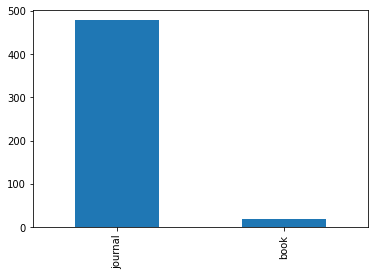

In [145]:
import matplotlib

venue_type_count = relational_publications_csv["venue_type"].value_counts()

venue_type_count.plot(kind="bar")
print(venue_type_count.plot)

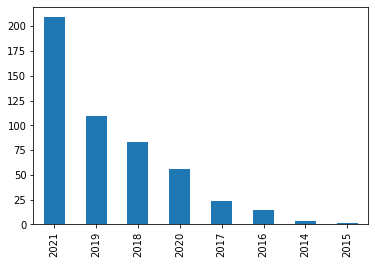

In [146]:
publication_year_count = relational_publications_csv["publication_year"].value_counts()
publication_year_count.plot(kind="bar")
print(publication_year_count.plot)

In [147]:
top_volume = relational_publications_csv["volume"].value_counts()[:20]
top_volume

11     29
13     22
10     18
18     12
9      11
14     11
116    10
16     10
2       9
28      9
121     8
7       8
21      8
12      8
27      6
15      6
23      6
115     6
99      5
33      5
Name: volume, dtype: int64

<AxesSubplot:>

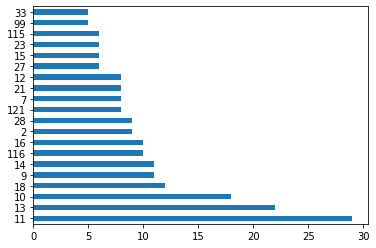

In [148]:
top_volume.plot(kind="barh")

In [149]:
publications_per_venue = relational_publications_csv["publication_venue"].value_counts()
publications_per_venue

Scientometrics                                                       50
Sustainability                                                       30
International Journal Of Environmental Research And Public Health    14
Journal Of Informetrics                                               9
Journal Of Cleaner Production                                         9
                                                                     ..
Current Psychology                                                    1
Geoderma                                                              1
European Journal Of Education                                         1
Architectural Science Review                                          1
Accountability In Research                                            1
Name: publication_venue, Length: 295, dtype: int64

In [150]:
publications_per_venue_sorted = publications_per_venue.sort_index()
publications_per_venue_sorted

3D Printing In Medicine                                                                                                   1
Accident Analysis & Prevention                                                                                            1
Accountability In Research                                                                                                1
Adbis, Tpdl And Eda 2020 Common Workshops And Doctoral Consortium - Communications In Computer And Information Science    1
Administrative Sciences                                                                                                   3
                                                                                                                         ..
Utilities Policy                                                                                                          1
Water, Air, & Soil Pollution                                                                                              2
Work    

### relational_other_data.json 
The file is a JSON (JavaScript Object Notation).
It is a dictionary containing 4 keys:
1. Key `"authors"` has a dictionary with many keys, it conncecs a publication (doi) with its authors(s)
     - Key `"doi"` has value a list of dictionaries:
         - Each dictionary has 3 keys: `"famly"`, `"given"`, `"orcid"`.
             - Each of these keys has a value a string.
2. Key `"venues_id"` has a value a dictionary with many keys, it conncects a publication (doi) with its publication venue
    - Key `"doi"` has value a lists of strings
        - The strings are either `"issn:..."` or `"isbn:..."`
            - ISSN = International Standard Serial Number
            - ISBN = International Standard Book Number
3. Key `"references"` has value a dictionary with many keys, it conncects a publication (doi) with other publication(s), these are the publications that are cited by our starting publication
    - Key `"doi"` has value a list of strings
        - The list can be empty or can contain any number of strings
            - The strings are `"doi:..."`
4. Key `"publishers"` has value a dictionary with many keys, it connects a publisher (crosssref) with its id (also crossref) and its name.
    - Key `"crossref:..."` has value a dictionary with 2 keys:
        - Crossref provides digital object identifiers (DOIs) for journal content (but not only this)
            - It was founded in 2000 by a group of publishers who needed an efficient method to connect their journal articles, and so began the use of DOIs to provide a way to link references between articles
        - Key `"id"` and key `"name"` have value a string

Since the structure is pretty different from the .csv file we might want to create a dataframe for each keys of our file. 


In [151]:
with open("testData/relational_other_data.json", "r", encoding="utf-8") as file:
    jsondata = json.load(file)

    # =============== AUTHORS DATAFRAME ===============
    authors_df = pd.DataFrame({
        "doi_authors": pd.Series(dtype="str"),
        "family": pd.Series(dtype="str"),
        "given": pd.Series(dtype="str"),
        "orcid": pd.Series(dtype="str")
    })

    family = []
    given = []
    orcid = []
    doi_authors = []

    authors = jsondata['authors']
    for key in authors:
        for value in authors[key]:
            doi_authors.append(key)
            family.append(value['family'])
            given.append(value['given'])
            orcid.append(value['orcid'])

    authors_df['doi_authors'] = doi_authors
    authors_df['family'] = family
    authors_df['given'] = given
    authors_df['orcid'] = orcid

    # =============== VENUES DATAFRAME ===============

    venues_id_df = pd.DataFrame({
        "doi_venues_id": pd.Series(dtype="str"),
        "issn_isbn": pd.Series(dtype="str"),
    })

    doi_venues_id = []
    issn_isbn = []

    venues_id = jsondata["venues_id"]
    for key in venues_id:
        for value in venues_id[key]:
            doi_venues_id.append(key)
            issn_isbn.append(value)

    venues_id_df["doi_venues_id"] = doi_venues_id
    venues_id_df["issn_isbn"] = pd.Series(issn_isbn)

    # =============== REFERENCES DATAFRAME ===============

    references_df = pd.DataFrame({
        "og_doi": pd.Series(dtype="str"),
        "ref_doi": pd.Series(dtype="str"),
    })

    og_doi = []
    ref_doi = []

    references = jsondata["references"]
    for key in references:
        for value in references[key]:
            og_doi.append(key)
            ref_doi.append(value)

    references_df["og_doi"] = pd.Series(og_doi)
    references_df["ref_doi"] = pd.Series(ref_doi)

    # =============== PUBLISHER DATAFRAME ===============

    publishers_df = pd.DataFrame({
        "crossref": pd.Series(dtype="str"),
        "id_crossref": pd.Series(dtype="str"),
        "name_pub": pd.Series(dtype="str")
    })

    crossref = []
    id_crossref = []
    name_pub = []

    publishers = jsondata["publishers"]
    for key in publishers:
        crossref.append(key)
        id_crossref.append(publishers[key]["id"])
        name_pub.append(publishers[key]["name"])

    publishers_df["crossref"] = pd.Series(crossref)
    publishers_df["id_crossref"] = pd.Series(id_crossref)
    publishers_df["name_pub"] = pd.Series(name_pub)

print("AUTHORS_DF", authors_df)
print("VENUES_ID_DF", venues_id_df)
print("REFERENCES_DF", references_df)
print("PUBLISHERS_DF", publishers_df)


AUTHORS_DF                             doi_authors    family           given  \
0               doi:10.1162/qss_a_00023    Peroni          Silvio   
1               doi:10.1162/qss_a_00023   Shotton           David   
2        doi:10.1007/s11192-019-03217-6     Heibi            Ivan   
3        doi:10.1007/s11192-019-03217-6    Peroni          Silvio   
4        doi:10.1007/s11192-019-03217-6   Shotton           David   
...                                 ...       ...             ...   
1133  doi:10.1080/00472778.2020.1776578    Amorós      J. Ernesto   
1134     doi:10.1007/s11301-020-00196-4     Simao  Lurdes Barroso   
1135     doi:10.1007/s11301-020-00196-4  Carvalho    Luísa Cagica   
1136     doi:10.1007/s11301-020-00196-4   Madeira      Maria José   
1137  doi:10.1080/08989621.2020.1836620       Ali           Imran   

                    orcid  
0     0000-0003-0530-4305  
1     0000-0001-5506-523X  
2     0000-0001-5366-5194  
3     0000-0003-0530-4305  
4     0000-0001-5506

This is what we've done for our upload Method. 

After we obtained our tables we are able to apply our methods to each of them.
First of all, in order to obtain an overview we are going to use the describe method:

In [152]:
print(authors_df.describe(include="all"))
print(venues_id_df.describe(include="all"))
print(references_df.describe(include="all"))
print(publishers_df.describe(include="all"))

                      doi_authors family      given                orcid
count                        1138   1138       1138                 1138
unique                        508    927        916                 1017
top     doi:10.1038/sdata.2016.18   Wang  Francisco  0000-0001-6593-7986
freq                           46     10          9                    8
                            doi_venues_id       issn_isbn
count                                 741             741
unique                                498             451
top     doi:10.1080/08989621.2020.1836620  issn:1588-2861
freq                                    2              50
                         og_doi                  ref_doi
count                       201                      201
unique                      134                       91
top     doi:10.1162/qss_a_00023  doi:10.1162/qss_a_00023
freq                          5                       20
             crossref    id_crossref            name_pub
cou

We're not able to compute values as "mean", "st", "min" etc.. because the values are not comparable. 
Now that we've our first description we may want to run some queeries:

In [153]:
print("-------------------------------------query for authors_df-----------------------------------------------")
aq = authors_df.query('family =="Wang"')
print(aq)
print("--------------------------------------query for venues_id_df------------------------------------------")
vq = venues_id_df.query('doi_venues_id == "doi:10.1080/08989621.2020.1836620"')
print(vq)
print("---------------------------------------query for references_df----------------------------------------")
rq = references_df.query('og_doi == "doi:10.1162/qss_a_00023"')
print(rq)
print("---------------------------------------query for publisher_df---------------------------------------")
pq = publishers_df.query('name_pub == "Codon Publications"')
print(pq)

-------------------------------------query for authors_df-----------------------------------------------
                              doi_authors family             given  \
254                doi:10.3390/su10030682   Wang              Peng   
453   doi:10.1016/j.socscimed.2019.112552   Wang              Yuxi   
585            doi:10.3390/ijerph18147358   Wang           Jinmiao   
588          doi:10.3390/recycling6020034   Wang  Cynthia Changxin   
720                  doi:10.1002/rra.3431   Wang               Jun   
723                     doi:10.2196/12625   Wang            Shimin   
760            doi:10.1002/adom.202100519   Wang              Zhen   
834         doi:10.1177/03128962211035470   Wang           Nengmin   
992               doi:10.3390/jmse9020218   Wang          Tianzhen   
1062               doi:10.1002/cjce.24127   Wang              Xiao   

                    orcid  
254   0000-0002-7842-9144  
453   0000-0002-9897-7316  
585   0000-0002-7587-5763  
588   0000-0

We now apply the unique method in order to retrieve all the unique given names in the `authors_df`.

In [154]:
print(authors_df["given"].unique())

['Silvio' 'David' 'Ivan' 'Yongjun' 'Mark D.' 'Michel' 'Ijsbrand Jan'
 'Gabrielle' 'Myles' 'Arie' 'Niklas' 'Jan-Willem' 'Luiz Bonino'
 'Philip E.' 'Anthony J.' 'Tim' 'Mercè' 'Ingrid' 'Olivier' 'Scott'
 'Chris T.' 'Richard' 'Alejandra' 'Alasdair J.G.' 'Paul' 'Carole'
 'Jeffrey S.' 'Jaap' 'Peter A.C' 'Rob' 'Tobias' 'Joost' 'Scott J.'
 'Maryann E.' 'Abel L.' 'Bengt' 'Philippe' 'Marco' 'Susanna-Assunta'
 'Erik' 'Thierry' 'Ted' 'Morris A.' 'Mark' 'Jan' 'Andra' 'Katherine' 'Jun'
 'Barend' 'B. Ian' 'Kirk L.' 'Matthew T.' 'Mario A.' 'Stephen A.'
 'George M.' 'Paolo' 'Aldo' 'Andrea Giovanni' 'Francesco' 'Valentina'
 'Egon' 'Angelo' 'Enrico' 'Viet Bach' 'Vojtěch' 'Gollam' 'Oscar'
 'Mohamad Yaser' 'Markus' 'Sören' 'Diego' 'Alexis-Michel' 'Alberto' 'Mike'
 'Enrique' 'Emilio' 'Marilena' 'Giovanni' 'Behnam' 'Anne' 'Philipp'
 'Matteo' 'Kevin W.' 'Peter' 'Xander' 'Lucas' 'Victor' 'O.' 'Martijn'
 'Nees Jan' 'Ludo' 'Bilal H.' 'Muhammad' 'Roderic D. M.' 'Marcos' 'Carlos'
 'José Luis' 'Josh M.' 'Milo' 'Pat

In [155]:
og_count = references_df["og_doi"].value_counts()
ref_count = references_df["ref_doi"].value_counts()
print("value counts of og_doi", og_count)
print("value counts of ref_doi", ref_count)

value counts of og_doi doi:10.1162/qss_a_00023                5
doi:10.3390/ijerph18115985             5
doi:10.3989/arbor.2021.799007          5
doi:10.3145/thinkepi.2021.e15e04       4
doi:10.7717/peerj-cs.421               3
                                      ..
doi:10.1016/j.resconrec.2018.09.029    1
doi:10.1016/j.foodchem.2018.06.139     1
doi:10.1007/s10668-020-01179-x         1
doi:10.1016/j.iref.2019.04.004         1
doi:10.1108/jic-02-2020-0054           1
Name: og_doi, Length: 134, dtype: int64
value counts of ref_doi doi:10.1162/qss_a_00023              20
doi:10.1038/sdata.2016.18            14
doi:10.1007/s11192-019-03217-6        9
doi:10.1016/j.joi.2014.07.006         9
doi:10.1016/j.ssci.2019.01.029        5
                                     ..
doi:10.1016/j.jbusres.2019.02.050     1
doi:10.1057/s41599-018-0175-8         1
doi:10.1007/s11192-019-03238-1        1
doi:10.3390/ijerph16111928            1
doi:10.1016/j.cmpb.2019.105075        1
Name: ref_doi, Length:

Wang                 10
Chen                  9
Patience              8
Peroni                7
Liu                   7
Hu                    5
Leydesdorff           5
Xu                    4
Li                    4
Zhou                  4
Merigó                4
Huang                 4
Manzano-Agugliaro     4
Yuan                  4
Sharifi               4
Shotton               4
Jin                   4
Yang                  3
Nazarovets            3
García-Lillo          3
Name: family, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


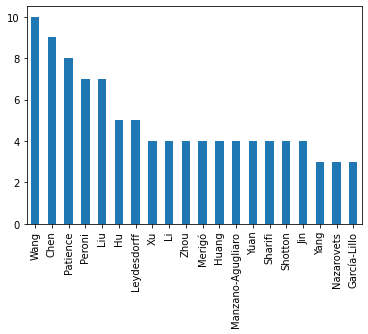

In [156]:
best_authors = authors_df["family"].value_counts()[:20]
print(best_authors)
print(best_authors.plot(kind="bar"))

AxesSubplot(0.260833,0.125;0.503333x0.755)


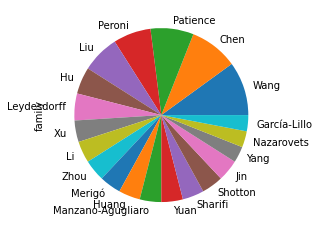

In [157]:
print(best_authors.plot(kind="pie"))

AxesSubplot(0.125,0.125;0.775x0.755)


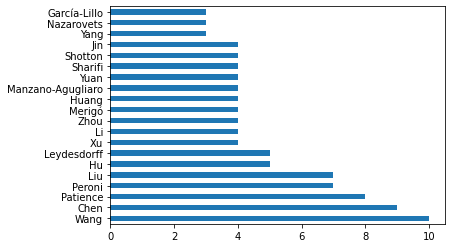

In [158]:
print(best_authors.plot(kind="barh"))

In [159]:
authors_per_orcid = authors_df["orcid"].value_counts()
print(authors_per_orcid)


0000-0001-6593-7986    8
0000-0003-0530-4305    7
0000-0002-4672-6961    5
0000-0002-7835-3098    5
0000-0001-5506-523X    4
                      ..
0000-0001-5115-7460    1
0000-0002-1608-4478    1
0000-0002-7978-6039    1
0000-0003-2910-3524    1
0000-0002-8912-5760    1
Name: orcid, Length: 1017, dtype: int64


In [160]:
authors_per_orcid_sorted = authors_per_orcid.sort_index()
print(authors_per_orcid_sorted)

0000-0001-5009-4242    1
0000-0001-5014-8749    1
0000-0001-5030-7260    1
0000-0001-5037-6485    1
0000-0001-5054-4506    1
                      ..
0000-0003-4882-9726    1
0000-0003-4900-3897    1
0000-0003-4957-1050    1
0000-0003-4968-5728    1
0000-0003-4970-0860    1
Name: orcid, Length: 1017, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


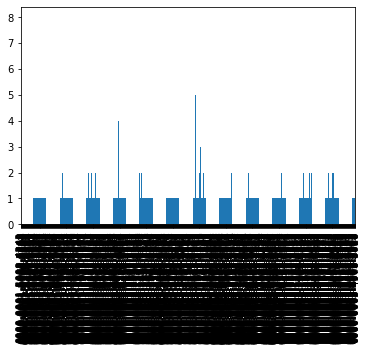

In [161]:
authors_per_orcid_sorted = authors_per_orcid.sort_index()
print(authors_per_orcid_sorted.plot(kind="bar"))

So now we're extending the same procedure to the other files, which are  "graph_publications.csv" and "graph_other_data.json."

In [162]:
graph_publications_csv = pd.read_csv("testData/graph_publications.csv") 
graph_publications_csv

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
0,doi:10.1016/j.websem.2021.100655,Crossing The Chasm Between Ontology Engineerin...,journal-article,2021,NaN,70,NaN,Journal Of Web Semantics,journal,crossref:78,NaN
1,doi:10.1007/s10115-017-1100-y,Core Techniques Of Question Answering Systems ...,journal-article,2017,3,55,NaN,Knowledge And Information Systems,journal,crossref:297,NaN
2,doi:10.1016/j.websem.2014.03.003,Api-Centric Linked Data Integration: The Open ...,journal-article,2014,NaN,29,NaN,Journal Of Web Semantics,journal,crossref:78,NaN
3,doi:10.1093/nar/gkz997,The Monarch Initiative In 2019: An Integrative...,journal-article,2019,D1,48,NaN,Nucleic Acids Research,journal,crossref:286,NaN
4,doi:10.3390/publications7030050,Dras-Tic Linked Data: Evenly Distributing The ...,journal-article,2019,3,7,NaN,Publications,journal,crossref:1968,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,doi:10.1145/3407194,Early Detection Of Social Media Hoaxes At Scale,journal-article,2020,4,14,NaN,Acm Transactions On The Web,journal,crossref:320,NaN
496,doi:10.3390/app10144893,Cognitive Aspects-Based Short Text Representat...,journal-article,2020,14,10,NaN,Applied Sciences,journal,crossref:1968,NaN
497,doi:10.1145/3309547,Temporal Relational Ranking For Stock Prediction,journal-article,2019,2,37,NaN,Acm Transactions On Information Systems,journal,crossref:320,NaN
498,doi:10.1007/978-3-030-58285-2_27,Fast Pathfinding In Knowledge Graphs Using Wor...,book-chapter,2020,NaN,NaN,1.0,Lecture Notes In Computer Science - Ki 2020: A...,book,crossref:297,NaN


In [163]:
info_graph_csv = graph_publications_csv.info() #getting some information from data without entirely looking at them.
info_graph_csv 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 500 non-null    object 
 1   title              500 non-null    object 
 2   type               500 non-null    object 
 3   publication_year   500 non-null    int64  
 4   issue              303 non-null    object 
 5   volume             391 non-null    object 
 6   chapter            93 non-null     float64
 7   publication_venue  486 non-null    object 
 8   venue_type         486 non-null    object 
 9   publisher          486 non-null    object 
 10  event              0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 43.1+ KB


In [164]:
description_g = graph_publications_csv.describe(include="all")
description_g # we're able to see some statistics values. 

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
count,500,500,500,500.000000,303,391,93.000000,486,486,486,0.0
unique,500,497,2,NaN,38,116,NaN,299,2,37,NaN
top,doi:10.1016/j.websem.2021.100655,Supply Chain Coordination Based On Web Service,journal-article,NaN,1,11,NaN,Applied Sciences,journal,crossref:297,NaN
freq,1,2,407,NaN,63,22,NaN,15,407,173,NaN
mean,NaN,NaN,NaN,2019.132000,NaN,NaN,0.849462,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.775636,NaN,NaN,0.359536,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2011.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2018.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2019.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2021.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


In [165]:
g1 = graph_publications_csv.query('publication_venue =="Applied Sciences"') #we want all the publications that have "Applied Sciencies" as publication_venue.
print("--this is the result of the first query", g1)

g2 = graph_publications_csv.query('title == "Supply Chain Coordination Based On Web Service"') #we want all the publications that have "Supply Chain Coordination Based on Web Service" as title.
print("--this is the result of the second query", g2)

--this is the result of the first query                            id  \
57     doi:10.3390/app9122553   
84    doi:10.3390/app11219825   
87    doi:10.3390/app12010143   
90    doi:10.3390/app12010287   
97    doi:10.3390/app11062813   
113   doi:10.3390/app11125633   
121   doi:10.3390/app11157056   
152   doi:10.3390/app10020591   
153   doi:10.3390/app10031040   
164   doi:10.3390/app10072277   
301   doi:10.3390/app11167233   
308  doi:10.3390/app112110450   
313   doi:10.3390/app10186328   
350    doi:10.3390/app9214547   
496   doi:10.3390/app10144893   

                                                 title             type  \
57   Ontoimm: An Ontology For Product Intelligent M...  journal-article   
84   Model And Knowledge Representation For The Reu...  journal-article   
87       Ontology-Based Nutritional Recommender System  journal-article   
90   Ontology-Driven Cultural Heritage Conservation...  journal-article   
97   Ontology-Based Semantic Conceptualisation Of H...  

In [166]:
median_g = graph_publications_csv["publication_year"].median() # here we want to compute the median of the publication years.
median_g

2019.0

In [167]:
mode_g = graph_publications_csv["publication_year"].mode() # here we want to compute the mode of the publication years.
mode_g

0    2021
Name: publication_year, dtype: int64

In [168]:
min_g = graph_publications_csv["publication_year"].min() # we're also able to compute the minimum
min_g

2011

In [169]:
max_g = graph_publications_csv["publication_year"].max() # same fo the maximum
max_g

2022

In [170]:
unique_values_publisher = graph_publications_csv["publisher"].unique()
print("--These are all the unique publishers", unique_values_publisher)
unique_values_type = graph_publications_csv["type"].unique()
print("--These are all the unique types", unique_values_type)
unique_values_vtype = graph_publications_csv["venue_type"].unique()
print("--These are all the unique venue types", unique_values_vtype)

--These are all the unique publishers ['crossref:78' 'crossref:297' 'crossref:286' 'crossref:1968' 'crossref:56'
 'crossref:8722' 'crossref:301' 'crossref:311' 'crossref:140'
 'crossref:98' 'crossref:7437' 'crossref:2432' 'crossref:2457'
 'crossref:179' 'crossref:2780' 'crossref:530' 'crossref:3742' nan
 'crossref:4340' 'crossref:735' 'crossref:263' 'crossref:22695'
 'crossref:6225' 'crossref:1010' 'crossref:11929' 'crossref:2373'
 'crossref:320' 'crossref:17207' 'crossref:265' 'crossref:316'
 'crossref:4443' 'crossref:340' 'crossref:2560' 'crossref:237'
 'crossref:2258' 'crossref:281' 'crossref:6951' 'crossref:374']
--These are all the unique types ['journal-article' 'book-chapter']
--These are all the unique venue types ['journal' 'book' nan]


In [171]:
count_type = graph_publications_csv["type"].value_counts()
print("------", count_type)
count_chapter = graph_publications_csv["chapter"].value_counts()
print("------", count_chapter)
count_p_venue = graph_publications_csv["publication_venue"].value_counts()
print("-----", count_p_venue)
count_p_year = graph_publications_csv["publication_year"].value_counts()
print("----", count_p_year)
count_publisher = graph_publications_csv["publisher"].value_counts()
print("---", count_publisher)

------ journal-article    407
book-chapter        93
Name: type, dtype: int64
------ 1.0    79
0.0    14
Name: chapter, dtype: int64
----- Applied Sciences                                                                    15
Journal Of Biomedical Semantics                                                     12
Nucleic Acids Research                                                              12
Expert Systems                                                                       8
The Semantic Web - Lecture Notes In Computer Science                                 7
                                                                                    ..
Journal Of Volcanology And Geothermal Research                                       1
Cirp Journal Of Manufacturing Science And Technology                                 1
Ecological Informatics                                                               1
Computer Science Review                                                       

AxesSubplot(0.125,0.125;0.775x0.755)


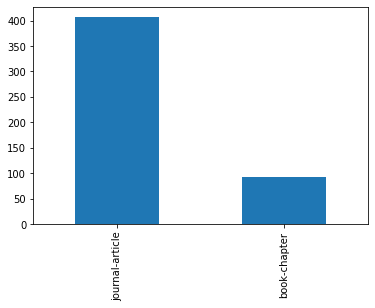

In [172]:
print(count_type.plot(kind="bar"))

AxesSubplot(0.125,0.125;0.775x0.755)


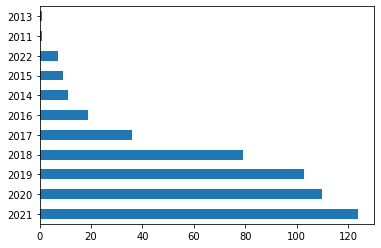

In [173]:
count_p_year = graph_publications_csv["publication_year"].value_counts()
print(count_p_year.plot(kind="barh"))

AxesSubplot(0.260833,0.125;0.503333x0.755)


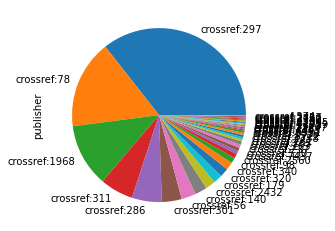

In [174]:
count_publisher = graph_publications_csv["publisher"].value_counts()
print(count_publisher.plot(kind="pie"))

In [175]:
best_publishers = graph_publications_csv["publisher"].value_counts()[:50]
print(best_publishers)

crossref:297      173
crossref:78        80
crossref:1968      57
crossref:311       30
crossref:286       27
crossref:301       18
crossref:56        13
crossref:140       11
crossref:2432       9
crossref:179        8
crossref:320        8
crossref:340        7
crossref:98         5
crossref:2560       4
crossref:7437       3
crossref:530        3
crossref:237        3
crossref:263        3
crossref:265        2
crossref:281        2
crossref:2258       2
crossref:8722       2
crossref:1010       2
crossref:6951       1
crossref:4443       1
crossref:316        1
crossref:735        1
crossref:17207      1
crossref:2373       1
crossref:11929      1
crossref:6225       1
crossref:22695      1
crossref:4340       1
crossref:3742       1
crossref:2780       1
crossref:2457       1
crossref:374        1
Name: publisher, dtype: int64


crossref:297      173
crossref:78        80
crossref:1968      57
crossref:311       30
crossref:286       27
crossref:301       18
crossref:56        13
crossref:140       11
crossref:2432       9
crossref:179        8
crossref:320        8
crossref:340        7
crossref:98         5
crossref:2560       4
crossref:7437       3
crossref:530        3
crossref:237        3
crossref:263        3
crossref:265        2
crossref:281        2
crossref:2258       2
crossref:8722       2
crossref:1010       2
crossref:6951       1
crossref:4443       1
crossref:316        1
crossref:735        1
crossref:17207      1
crossref:2373       1
crossref:11929      1
crossref:6225       1
crossref:22695      1
crossref:4340       1
crossref:3742       1
crossref:2780       1
crossref:2457       1
crossref:374        1
Name: publisher, dtype: int64


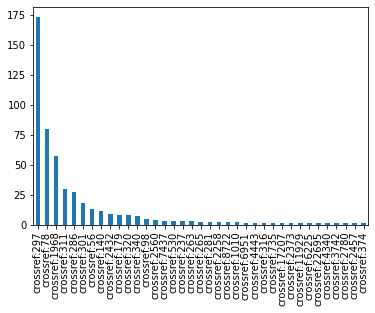

In [176]:
best_publishers.plot(kind="bar")
print(best_publishers)

In [177]:
best_publishers_sort = best_publishers.sort_index()
print(best_publishers_sort)

crossref:1010       2
crossref:11929      1
crossref:140       11
crossref:17207      1
crossref:179        8
crossref:1968      57
crossref:2258       2
crossref:22695      1
crossref:237        3
crossref:2373       1
crossref:2432       9
crossref:2457       1
crossref:2560       4
crossref:263        3
crossref:265        2
crossref:2780       1
crossref:281        2
crossref:286       27
crossref:297      173
crossref:301       18
crossref:311       30
crossref:316        1
crossref:320        8
crossref:340        7
crossref:374        1
crossref:3742       1
crossref:4340       1
crossref:4443       1
crossref:530        3
crossref:56        13
crossref:6225       1
crossref:6951       1
crossref:735        1
crossref:7437       3
crossref:78        80
crossref:8722       2
crossref:98         5
Name: publisher, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


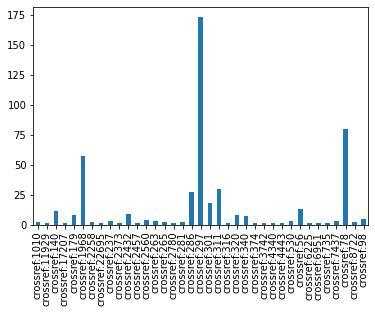

In [178]:
bpplot = best_publishers_sort.plot(kind="bar")
print(bpplot)

In [179]:
with open("testData/graph_other_data.json", "r", encoding="utf-8") as file:
    jsondata = json.load(file)

    # =============== AUTHORS DATAFRAME ===============
    authors_df = pd.DataFrame({
        "doi_authors": pd.Series(dtype="str"),
        "family": pd.Series(dtype="str"),
        "given": pd.Series(dtype="str"),
        "orcid": pd.Series(dtype="str")
    })

    family = []
    given = []
    orcid = []
    doi_authors = []

    authors = jsondata['authors']
    for key in authors:
        for value in authors[key]:
            doi_authors.append(key)
            family.append(value['family'])
            given.append(value['given'])
            orcid.append(value['orcid'])

    authors_df['doi_authors'] = doi_authors
    authors_df['family'] = family
    authors_df['given'] = given
    authors_df['orcid'] = orcid

    # =============== VENUES DATAFRAME ===============

    venues_id_df = pd.DataFrame({
        "doi_venues_id": pd.Series(dtype="str"),
        "issn_isbn": pd.Series(dtype="str"),
    })

    doi_venues_id = []
    issn_isbn = []

    venues_id = jsondata["venues_id"]
    for key in venues_id:
        for value in venues_id[key]:
            doi_venues_id.append(key)
            issn_isbn.append(value)

    venues_id_df["doi_venues_id"] = doi_venues_id
    venues_id_df["issn_isbn"] = pd.Series(issn_isbn)

    # =============== REFERENCES DATAFRAME ===============

    references_df = pd.DataFrame({
        "og_doi": pd.Series(dtype="str"),
        "ref_doi": pd.Series(dtype="str"),
    })

    og_doi = []
    ref_doi = []

    references = jsondata["references"]
    for key in references:
        for value in references[key]:
            og_doi.append(key)
            ref_doi.append(value)

    references_df["og_doi"] = pd.Series(og_doi)
    references_df["ref_doi"] = pd.Series(ref_doi)

    # =============== PUBLISHER DATAFRAME ===============

    publishers_df = pd.DataFrame({
        "crossref": pd.Series(dtype="str"),
        "id_crossref": pd.Series(dtype="str"),
        "name_pub": pd.Series(dtype="str")
    })

    crossref = []
    id_crossref = []
    name_pub = []

    publishers = jsondata["publishers"]
    for key in publishers:
        crossref.append(key)
        id_crossref.append(publishers[key]["id"])
        name_pub.append(publishers[key]["name"])

    publishers_df["crossref"] = pd.Series(crossref)
    publishers_df["id_crossref"] = pd.Series(id_crossref)
    publishers_df["name_pub"] = pd.Series(name_pub)

print("AUTHORS_DF", authors_df)
print("VENUES_ID_DF", venues_id_df)
print("REFERENCES_DF", references_df)
print("PUBLISHERS_DF", publishers_df)


AUTHORS_DF                            doi_authors          family    given  \
0     doi:10.1016/j.websem.2021.100655  Espinoza-Arias    Paola   
1     doi:10.1016/j.websem.2021.100655          Garijo   Daniel   
2     doi:10.1016/j.websem.2021.100655          Corcho    Oscar   
3        doi:10.1007/s10115-017-1100-y      Diefenbach   Dennis   
4     doi:10.1016/j.websem.2014.03.003           Groth     Paul   
...                                ...             ...      ...   
1427               doi:10.1145/3309547            Wang    Xiang   
1428  doi:10.1007/978-3-030-58285-2_27          Martin     Leon   
1429  doi:10.1007/978-3-030-58285-2_27       Boockmann   Jan H.   
1430  doi:10.1007/978-3-030-58285-2_27         Henrich  Andreas   
1431    doi:10.1007/s11280-020-00842-7              Li      Lin   

                    orcid  
0     0000-0002-3938-2064  
1     0000-0003-0454-7145  
2     0000-0002-9260-0753  
3     0000-0002-0046-2219  
4     0000-0003-0183-6910  
...             

In [180]:
print(authors_df.describe(include="all"))
print(venues_id_df.describe(include="all"))
print(references_df.describe(include="all"))
print(publishers_df.describe(include="all"))

                           doi_authors family  given                orcid
count                             1432   1432   1432                 1432
unique                             526   1094   1052                 1184
top     doi:10.1016/j.xgen.2021.100029  Zhang  David  0000-0002-0736-9199
freq                               160     15     12                   11
                           doi_venues_id       issn_isbn
count                                754             754
unique                               486             488
top     doi:10.1007/978-3-030-20485-3_11  issn:2076-3417
freq                                   2              15
                        og_doi                 ref_doi
count                      310                     310
unique                     169                      99
top     doi:10.1093/nar/gkz997  doi:10.1093/nar/gkz997
freq                        16                      39
            crossref   id_crossref             name_pub
count         

In [181]:
og_count = references_df["og_doi"].value_counts()
ref_count = references_df["ref_doi"].value_counts()
print("value counts of og_doi", og_count)
print("value counts of ref_doi", ref_count)

value counts of og_doi doi:10.1093/nar/gkz997               16
doi:10.1016/j.websem.2021.100655      7
doi:10.1093/nar/gkaa1043              6
doi:10.1093/jamiaopen/ooaa030         6
doi:10.1371/journal.pcbi.1008376      6
                                     ..
doi:10.1016/j.aei.2018.10.009         1
doi:10.1016/j.pmcj.2016.03.001        1
doi:10.1080/15230406.2019.1647797     1
doi:10.1007/s00778-019-00564-x        1
doi:10.1007/s13218-020-00686-3        1
Name: og_doi, Length: 169, dtype: int64
value counts of ref_doi doi:10.1093/nar/gkz997              39
doi:10.1038/sdata.2016.18           33
doi:10.1007/s10115-017-1100-y       26
doi:10.1093/nar/gky1105             14
doi:10.1016/j.websem.2014.03.003    13
                                    ..
doi:10.3390/app9122553               1
doi:10.1007/s00607-019-00701-y       1
doi:10.1016/j.jbi.2018.06.008        1
doi:10.1007/s00778-019-00564-x       1
doi:10.1007/978-3-030-22102-7_21     1
Name: ref_doi, Length: 99, dtype: int64


Zhang              15
Wang               13
Robinson           11
Li                 10
Hoehndorf          10
Valencia-García     7
García-Sánchez      6
Groth               6
Slater              5
Chen                5
Haendel             5
Smith               5
Köhler              5
Page                5
Vasilevsky          5
Pal                 5
Lu                  4
Liu                 4
Zorn                4
Janssen             4
Name: family, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


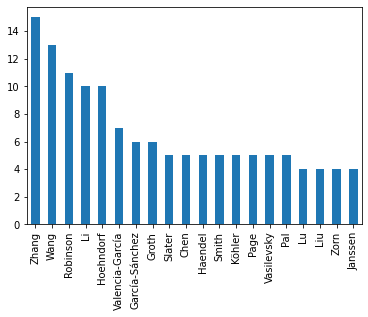

In [182]:
best_authors = authors_df["family"].value_counts()[:20]
print(best_authors)
print(best_authors.plot(kind="bar"))

AxesSubplot(0.260833,0.125;0.503333x0.755)


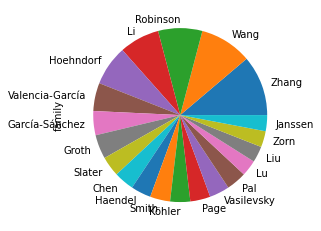

In [183]:
print(best_authors.plot(kind="pie"))

AxesSubplot(0.125,0.125;0.775x0.755)


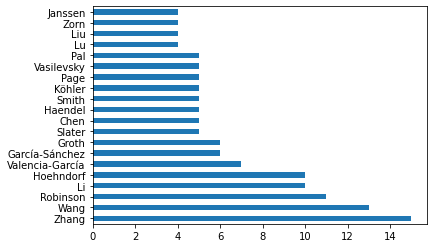

In [184]:
print(best_authors.plot(kind="barh"))

In [185]:
authors_per_orcid = authors_df["orcid"].value_counts()
print(authors_per_orcid)


0000-0002-0736-9199    11
0000-0001-8149-5890    10
0000-0003-2457-1791     8
0000-0003-0183-6910     6
0000-0003-2667-5359     6
                       ..
0000-0002-0072-8881     1
0000-0001-9444-0848     1
0000-0002-9652-5164     1
0000-0003-1631-5931     1
0000-0001-7553-6916     1
Name: orcid, Length: 1184, dtype: int64


In [186]:
authors_per_orcid_sorted = authors_per_orcid.sort_index()
print(authors_per_orcid_sorted)

0000-0001-5012-0420    1
0000-0001-5036-9365    1
0000-0001-5044-2921    1
0000-0001-5069-1370    1
0000-0001-5087-8776    1
                      ..
0000-0003-4904-2511    1
0000-0003-4905-0941    1
0000-0003-4920-9553    1
0000-0003-4953-1390    1
0000-0003-4984-1532    1
Name: orcid, Length: 1184, dtype: int64
